**Начнем с импортирования библиотек**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
pd.set_option ('display.max_columns', None)

In [2]:
import pandas as pd, numpy as np, seaborn as sns, matplotlib.pyplot as plt
from scipy.stats import chi2_contingency, mannwhitneyu
from statsmodels.stats.proportion import proportions_ztest

In [3]:
import pandas as pd, numpy as np, seaborn as sns, matplotlib.pyplot as plt
from scipy.stats import norm, mannwhitneyu, chi2_contingency
from statsmodels.stats.proportion import proportion_confint
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
sns.set_theme(style="whitegrid")

In [ ]:
!pip install --quiet pyarrow

In [4]:
from collections import Counter
import pyarrow.parquet as pq

In [5]:
from scipy.stats import chi2_contingency, mannwhitneyu, norm
from statsmodels.stats.proportion import proportion_confint
sns.set_theme(style='whitegrid')

**historical_currency_exchange**


---

Вспомогательные данные для перевода операций в нужную валюту. Обменный курс с `2024-09-30` по `2024-10-30` относительно `USD`.

| Поле | Описание | Тип |
|------|----------|-----|
| `date` | Дата обменного курса | Date |
| `AUD` | Австралийский доллар | Float64 |
| `BRL` | Бразильский реал | Float64 |
| `CAD` | Канадский доллар | Float64 |
| `EUR` | Евро | Float64 |
| `GBP` | Британский фунт стерлингов | Float64 |
| `JPY` | Японская иена | Float64 |
| `MXN` | Мексиканское песо | Float64 |
| `NGN` | Нигерийская найра | Float64 |
| `RUB` | Российский Рубль | Float64 |
| `SGD` | Сингапурский доллар | Float64 |
| `USD` | Доллар США | Int64 |

In [6]:
exchange_rates =  pd.read_parquet('/content/historical_currency_exchange.parquet')

**transaction_fraud_data**



---

Этот анонимизированный набор данных реальных финансовые транзакции, который предназначен для разработки и тестирования моделей выявления мошеннических операций.

Он охватывает различные сценарии — от розничной торговли и ресторанов до путешествий и здравоохранения — и включает как легитимные, так и мошеннические операции. В нём представлены важные признаки, влияющие на распознавание мошенничества: сумма, тип устройства, география, валюта, тип карты и метка `is_fraud`.

| Поле | Описание | Тип |
|------|----------|-----|
| `transaction_id` | Уникальный идентификатор транзакции | String |
| `customer_id` | Уникальный идентификатор клиента | String |
| `card_number` | Маскированный номер карты | Int64 |
| `timestamp` | Дата и время транзакции | Datetime(time_unit='us') |
| `vendor_category` | Общая категория вендора (например, Розница, Путешествия) | String |
| `vendor_type` | Тип вендора внутри категории (например, "онлайн") | String |
| `vendor` | Название вендора | String |
| `amount` | Сумма транзакции | Float64 |
| `currency` | Валюта (например, USD, EUR, JPY) | String |
| `country` | Страна, где проведена транзакция | String |
| `city` | Город, где проведена транзакция | String |
| `city_size` | Размер города (например, средний, крупный) | String |
| `card_type` | Тип карты (например, Basic Credit, Gold Credit) | String |
| `is_card_present` | Присутствовала ли карта физически при оплате (POS) | Boolean |
| `device` | Устройство, с которого проведена транзакция (например, Chrome, iOS App) | String |
| `channel` | Канал проведения транзакции (веб, мобильный, POS) | String |
| `device_fingerprint` | Уникальный отпечаток устройства | String |
| `ip_address` | IP-адрес транзакции | String |
| `is_outside_home_country` | Признак того, что операция проведена вне страны клиента | Boolean |
| `is_high_risk_vendor` | Является ли категория вендора рискованной (например, Путешествия, Развлечения) | Boolean |
| `is_weekend` | Произошла ли операция в выходной день | Boolean |
| `last_hour_activity` | Показатели активности за последний час в виде вложенной структуры | Struct({'num_transactions': Int64, 'total_amount': Float64, 'unique_merchants': Int64, 'unique_countries': Int64, 'max_single_amount': Float64}) |
| `is_fraud` | Является ли транзакция мошеннической (`True` / `False`) | Boolean |

In [7]:
transactions = pd.read_parquet('/content/transaction_fraud_data.parquet')

# Общий анализ датасета

In [ ]:
print(transactions.shape)
print(transactions.dtypes)
print(transactions.head(5))
print(transactions.isna().sum())

(7483766, 23)
transaction_id                     object
customer_id                        object
card_number                         int64
timestamp                  datetime64[us]
vendor_category                    object
vendor_type                        object
vendor                             object
amount                            float64
currency                           object
country                            object
city                               object
city_size                          object
card_type                          object
is_card_present                      bool
device                             object
channel                            object
device_fingerprint                 object
ip_address                         object
is_outside_home_country              bool
is_high_risk_vendor                  bool
is_weekend                           bool
last_hour_activity                 object
is_fraud                             bool
dtype: object
  tran

In [ ]:
print(exchange_rates.shape)
print(exchange_rates.dtypes)
print(exchange_rates.head(5))
print(exchange_rates.isna().sum())

(31, 12)
date     object
AUD     float64
BRL     float64
CAD     float64
EUR     float64
GBP     float64
JPY     float64
MXN     float64
NGN     float64
RUB     float64
SGD     float64
USD       int64
dtype: object
         date       AUD       BRL       CAD       EUR       GBP         JPY  \
0  2024-09-30  1.443654  5.434649  1.351196  0.895591  0.747153  142.573268   
1  2024-10-01  1.442917  5.444170  1.352168  0.897557  0.746956  143.831429   
2  2024-10-02  1.449505  5.425444  1.348063  0.903056  0.752241  143.806861   
3  2024-10-03  1.456279  5.442044  1.351451  0.906018  0.754584  146.916773   
4  2024-10-04  1.460930  5.477788  1.355260  0.906452  0.761891  146.592323   

         MXN          NGN        RUB       SGD  USD  
0  19.694724  1668.736400  94.133735  1.280156    1  
1  19.667561  1670.694524  92.898519  1.284352    1  
2  19.606748  1669.653006  94.583198  1.286983    1  
3  19.457701  1670.097873  95.655442  1.294391    1  
4  19.363467  1649.763738  94.755337  1.

Для удобства оценки данных переведем все данные в одну валюту — доллары

In [8]:
transactions['date'] = pd.to_datetime(transactions['timestamp']).dt.date
transactions['currency'] = transactions['currency'].str.upper()

rates_long = exchange_rates.melt(
    id_vars='date',
    var_name='currency',
    value_name='rate_per_usd'
)

transactions = transactions.merge(
    rates_long,
    on=['date', 'currency'],
    how='left'
)

transactions['amount_usd'] = transactions['amount'] / transactions['rate_per_usd']

print(transactions[['amount', 'currency', 'rate_per_usd', 'amount_usd']].head())
print(f"Пропущенных курсов: {transactions['rate_per_usd'].isna().sum()}")

      amount currency  rate_per_usd  amount_usd
0     294.87      GBP      0.747153  394.658011
1    3368.97      BRL      5.434649  619.905757
2  102582.38      JPY    142.573268  719.506409
3     630.60      AUD      1.443654  436.808287
4  724949.27      NGN   1668.736400  434.430069
Пропущенных курсов: 0


In [ ]:
fraud_counts = transactions['is_fraud'].value_counts()
print(fraud_counts)
fraud_ratio = fraud_counts[1] / len(transactions) * 100
print(f"Доля мошеннических транзакций: {fraud_ratio:.3f}%")

is_fraud
False    5989047
True     1494719
Name: count, dtype: int64
Доля мошеннических транзакций: 19.973%


/tmp/ipython-input-2325391664.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  fraud_ratio = fraud_counts[1] / len(transactions) * 100


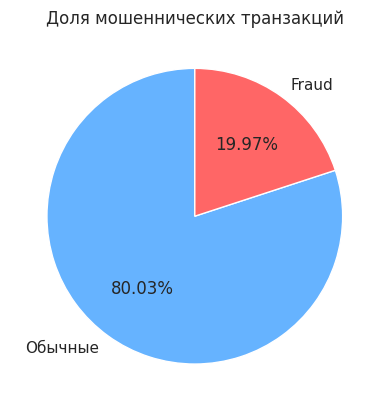

In [ ]:
import matplotlib.pyplot as plt
labels = ['Обычные', 'Fraud']
plt.pie(fraud_counts, labels=labels, autopct='%1.2f%%', startangle=90, colors=['#66b3ff','#ff6666'])
plt.title("Доля мошеннических транзакций")
plt.show()

In [ ]:
country_fraud = transactions.groupby(['country', 'is_fraud']).size().reset_index(name='count')
print(country_fraud.head(6))

     country  is_fraud   count
0  Australia     False  459043
1  Australia      True   37652
2     Brazil     False  506171
3     Brazil      True  298629
4     Canada     False  495354
5     Canada      True   37278


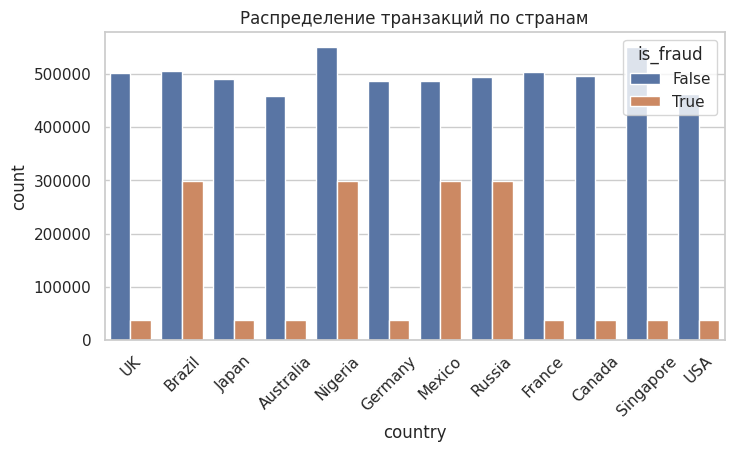

In [ ]:
import seaborn as sns
plt.figure(figsize=(8,4))
sns.countplot(data=transactions, x='country', hue='is_fraud')
plt.title("Распределение транзакций по странам")
plt.xticks(rotation=45)
plt.show()

In [ ]:
fraud_by_country = Counter()
TRANSACTION_FILE = '/content/transaction_fraud_data.parquet'
pf = pq.ParquetFile(TRANSACTION_FILE)

for batch in pf.iter_batches(columns=['country', 'is_fraud'], batch_size=50_000):
    tbl   = batch.to_pandas()
    mask  = tbl['is_fraud'] == True
    fraud_by_country.update(tbl.loc[mask, 'country'].value_counts().to_dict())

fraud_series = pd.Series(fraud_by_country).sort_values(ascending=False)
avg_fraud    = fraud_series.mean()

above_avg = fraud_series[fraud_series > avg_fraud]

print(f"Среднее число fraud‑операций на страну: {avg_fraud:.2f}\n")

Среднее число fraud‑операций на страну: 124559.92



In [ ]:
display_df = (
    above_avg
    .reset_index()
    .rename(columns={'index': 'country', 0: 'fraud_transactions'})
)
display_df

,country,fraud_transactions
0,Russia,299425
1,Mexico,298841
2,Brazil,298629
3,Nigeria,298600


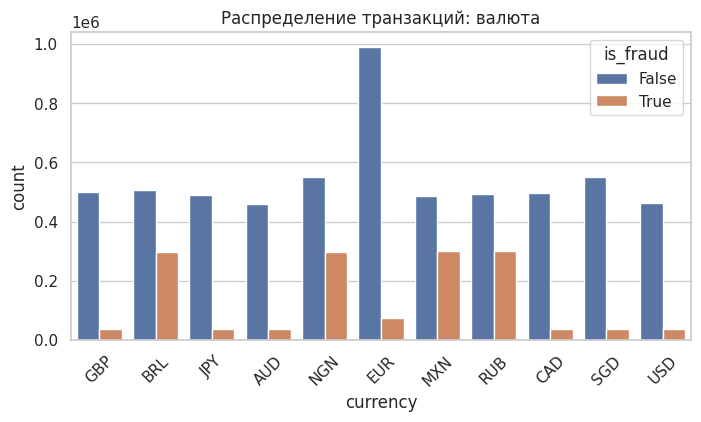

In [ ]:
import seaborn as sns
plt.figure(figsize=(8,4))
sns.countplot(data=transactions, x='currency', hue='is_fraud')
plt.title("Распределение транзакций: валюта")
plt.xticks(rotation=45)
plt.show()

По распределению транзакций по странам выделим четыре страны с примерно равным количеством мошеннических, при этом данные количества больше, чем среднее по всем странам. Среди стран выделяются: Россия, Мексика, Бразилия и Нигерия. График распределения транзакций по валютам дополняет график с горячими точками мошеннических операций по странам.

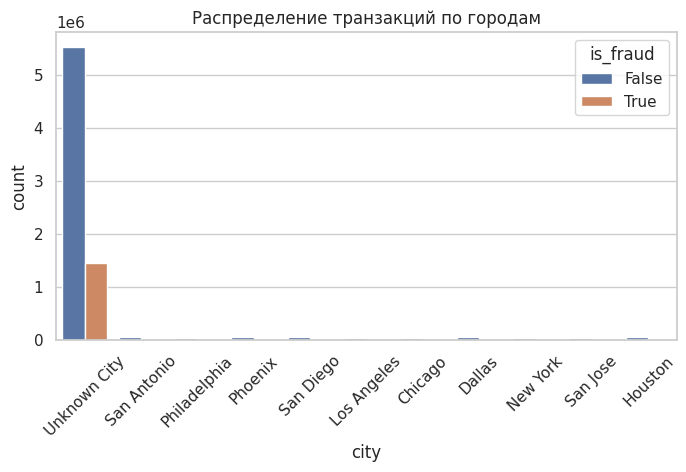

In [ ]:
import seaborn as sns
plt.figure(figsize=(8,4))
sns.countplot(data=transactions, x='city', hue='is_fraud')
plt.title("Распределение транзакций по городам")
plt.xticks(rotation=45)
plt.show()

Отметим, что в основном города для транзакций не указаны, поэтому данное поле не несет большой роли в определении типа транзакции.

χ²‑p‑value = 0.000e+00,  Cramér’s V = 0.371


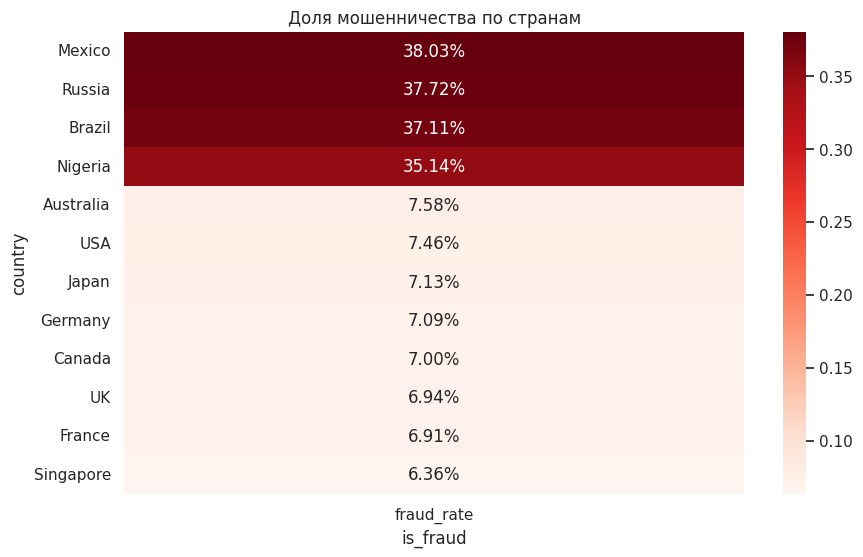

In [ ]:
country_tbl = (
    transactions.pivot_table(index='country',
                   columns='is_fraud',
                   aggfunc='size',
                   fill_value=0)
      .rename(columns={False: 'legit', True: 'fraud'})
)

country_tbl['fraud_rate'] = country_tbl['fraud'] / country_tbl[['legit', 'fraud']].sum(axis=1)

from scipy.stats import chi2_contingency
chi2, p, _, _ = chi2_contingency(country_tbl[['legit', 'fraud']])
cramer_v = np.sqrt(chi2 / (country_tbl[['legit','fraud']].values.sum() *
                           (min(country_tbl[['legit','fraud']].shape)-1)))
print(f'χ²‑p‑value = {p:.3e},  Cramér’s V = {cramer_v:.3f}')

import seaborn as sns, matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
sns.heatmap(country_tbl[['fraud_rate']].sort_values('fraud_rate', ascending=False),
            annot=True, fmt='.2%', cmap='Reds')
plt.title('Доля мошенничества по странам')
plt.show()

**Основные выводы по странам:**

* для Mexico/Russia/Brazil/Nigeria нужны жёсткие правила — количество мошеннических операций в данных странах в 5–6 раз больше, чем у остальных

* для остальных стран можно снижать внимание, оставляя основной упор на другие признаки

* для проверки гипотезы связи факта мошенничества и страны операции используем Критерий V Крамера, который покажет так называемуб корреляцию между двумя категориальными признаками

* страна — мощный предиктор: само по себе происхождение транзакции объясняет значительную долю вариации fraud (V ≈ 0.37), низкое значение p–value показывает, что разница в долях мошенничества по странам не возникла случайно

* в качестве стратегии можно добавить столбец is_high_risk_country, который будет показывать находится ли страна в зоне риска

**Продуктовые и технические гипотезы**

* автоматическое снижение суточного лимита при операциях из горячих стран, тем более если клиент раньше там не платил

* push/SMS‑подтверждение, когда страна операции ∉ «белого списка», особенно для больших сумм

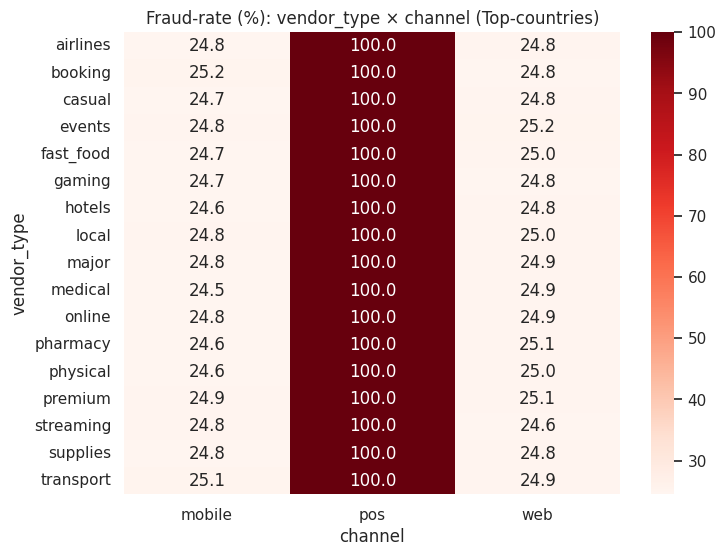

In [ ]:
top_countries = ['Mexico','Russia','Brazil','Nigeria']
cube = (transactions[transactions.country.isin(top_countries)]
          .pivot_table(index='vendor_type', columns='channel',
                       values='is_fraud', aggfunc='mean')
          .mul(100))
plt.figure(figsize=(8,6))
sns.heatmap(cube, cmap='Reds', fmt='.1f', annot=True)
plt.title('Fraud‑rate (%): vendor_type × channel (Top‑countries)')
plt.show()

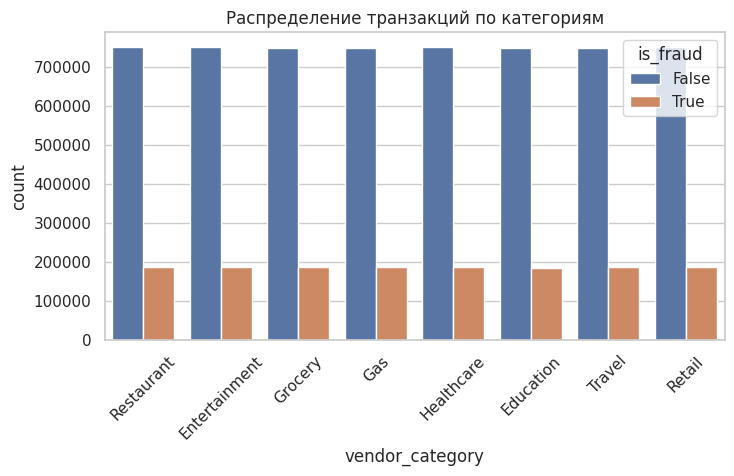

In [ ]:
import seaborn as sns
plt.figure(figsize=(8,4))
sns.countplot(data=transactions, x='vendor_category', hue='is_fraud')
plt.title("Распределение транзакций по категориям")
plt.xticks(rotation=45)
plt.show()

Доля мошеннических/немошеннических транзакций равномерно (с
небольшой разницей) распределены между категориями.




In [ ]:
def wilson(k, n, alpha=0.05):
    if n == 0: return (np.nan, np.nan)
    z = norm.ppf(1 - alpha/2)
    phat = k / n
    denom = 1 + z**2/n
    centre = phat + z**2/(2*n)
    adj = z*np.sqrt(phat*(1-phat)/n + z**2/(4*n**2))
    return ( (centre - adj)/denom, (centre + adj)/denom )

In [ ]:
vt = (transactions.groupby('vendor_type')['is_fraud']
        .agg(['sum','count'])
        .rename(columns={'sum':'fraud', 'count':'total'}))
vt['fraud_rate'] = vt['fraud'] / vt['total']

vt[['ci_low','ci_up']] = vt.apply(lambda r: wilson(r['fraud'], r['total']), axis=1, result_type='expand')
vt = vt.sort_values('fraud_rate', ascending=False)

print('Top‑10 risk vendor_type')
display(vt.head(10).style.format({'fraud_rate': '{:.2%}', 'ci_low':'{:.2%}', 'ci_up':'{:.2%}'}))
print('\nBottom‑10 risk vendor_type')
display(vt.tail(10).style.format({'fraud_rate': '{:.2%}', 'ci_low':'{:.2%}', 'ci_up':'{:.2%}'}))

Top‑10 risk vendor_type


,fraud,total,fraud_rate,ci_low,ci_up
vendor_type,,,,,
transport,47069,233977,20.12%,19.95%,20.28%
fast_food,62786,312805,20.07%,19.93%,20.21%
airlines,46820,233476,20.05%,19.89%,20.22%
physical,187200,935039,20.02%,19.94%,20.10%
booking,46846,234026,20.02%,19.86%,20.18%
events,62525,312598,20.00%,19.86%,20.14%
major,93416,467499,19.98%,19.87%,20.10%
pharmacy,93569,468377,19.98%,19.86%,20.09%
supplies,93240,466765,19.98%,19.86%,20.09%



Bottom‑10 risk vendor_type


,fraud,total,fraud_rate,ci_low,ci_up
vendor_type,,,,,
pharmacy,93569,468377,19.98%,19.86%,20.09%
supplies,93240,466765,19.98%,19.86%,20.09%
local,93413,467902,19.96%,19.85%,20.08%
gaming,62159,311484,19.96%,19.82%,20.10%
hotels,46742,234311,19.95%,19.79%,20.11%
streaming,62206,312091,19.93%,19.79%,20.07%
online,279363,1401650,19.93%,19.86%,20.00%
casual,62082,311678,19.92%,19.78%,20.06%
premium,62083,311695,19.92%,19.78%,20.06%


In [ ]:
cont_vt = pd.crosstab(transactions['vendor_type'], transactions['is_fraud'])
chi2, p, _, _ = chi2_contingency(cont_vt)
print(f'χ²‑p‑value vendor_type vs fraud  =  {p:.3e}')

χ²‑p‑value vendor_type vs fraud  =  7.042e-01


Данная таблица является подверждением того, что отдельно взятые типы категорий, не помогают распознавать мошеннические операции.

In [ ]:
highrisk_tbl = pd.crosstab(transactions['is_high_risk_vendor'], transactions['is_fraud'], normalize='index')
print('\nFraud‑rate для is_high_risk_vendor:')
print(highrisk_tbl)


Fraud‑rate для is_high_risk_vendor:
is_fraud                False     True 
is_high_risk_vendor                    
False                0.800358  0.199642
True                 0.800014  0.199986


In [ ]:
chi2,p,_,_ = chi2_contingency(pd.crosstab(transactions['is_high_risk_vendor'], transactions['is_fraud']))
print(f'χ²‑p = {p:.3e}')

χ²‑p = 3.081e-01


In [ ]:
vt_stats = (transactions.groupby('vendor_type')['is_fraud']
              .mean()
              .mul(100)
              .sort_values(ascending=False))
print('\nTop‑10 vendor_type по fraud‑rate (%):\n', vt_stats.head(10).round(2))


Top‑10 vendor_type по fraud‑rate (%):
 vendor_type
transport    20.12
fast_food    20.07
airlines     20.05
physical     20.02
booking      20.02
events       20.00
major        19.98
pharmacy     19.98
supplies     19.98
local        19.96
Name: is_fraud, dtype: float64


**Основные выводы по типам категорий:**

* бинарная метка «high‑risk vendor» ничего не добавляет к объяснению мошенничества, разница в долях минимальна

* возможно данный признак считался неверно и его стоит пересмотреть к использованию после пересчета

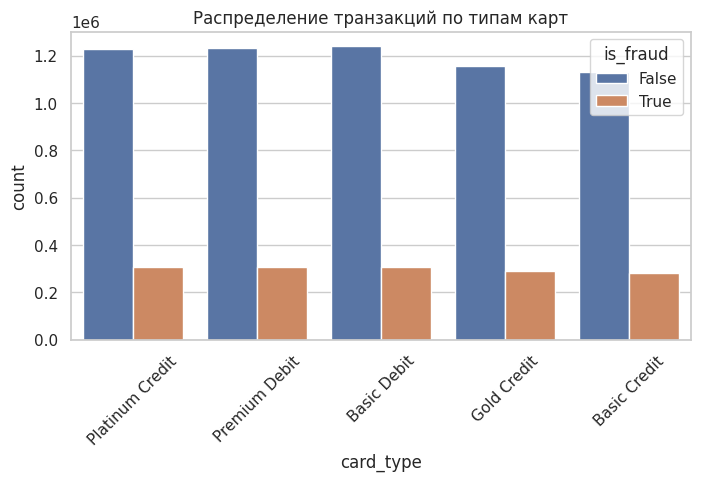

In [ ]:
import seaborn as sns
plt.figure(figsize=(8,4))
sns.countplot(data=transactions, x='card_type', hue='is_fraud')
plt.title("Распределение транзакций по типам карт")
plt.xticks(rotation=45)
plt.show()

Доля мошеннических/немошеннических транзакций равномерно (с небольшой разницей) распределены между типами карт держателей.

In [ ]:
def wilson_ci(k, n, alpha=0.05):
    if n == 0:
        return (np.nan, np.nan)
    z = norm.ppf(1 - alpha / 2)
    phat = k / n
    denom = 1 + z ** 2 / n
    centre = phat + z**2/(2*n)
    adj = z * np.sqrt(phat*(1-phat)/n + z**2/(4*n**2))
    lower = (centre - adj) / denom
    upper = (centre + adj) / denom
    return lower, upper

In [ ]:
transactions['is_credit'] = transactions['card_type'].str.contains('Credit', case=False)
ct_cd = pd.crosstab(transactions['is_credit'], transactions['is_fraud'])

a, b = ct_cd.loc[True]
c, d = ct_cd.loc[False]
or_credit_debit = (a/b) / (c/d)

se = np.sqrt(1/a + 1/b + 1/c + 1/d)
ci_low, ci_high = np.exp(np.log(or_credit_debit) + np.array([-1,1]) * 1.96 * se)

print(f'\n[Card] Odds‑ratio CREDIT vs DEBIT = {or_credit_debit:.2f} '
      f'(95% CI {ci_low:.2f}–{ci_high:.2f})')


[Card] Odds‑ratio CREDIT vs DEBIT = 1.00 (95% CI 1.00–1.00)


In [ ]:
transactions['is_premium'] = transactions['card_type'].str.contains('Premium|Gold|Platinum', case=False)
ct_pb = pd.crosstab(transactions['is_premium'], transactions['is_fraud'])
a,b = ct_pb.loc[True]; c,d = ct_pb.loc[False]
or_premium_basic = (a/b)/(c/d)
se = np.sqrt(1/a+1/b+1/c+1/d)
ci_low,ci_high = np.exp(np.log(or_premium_basic)+np.array([-1,1])*1.96*se)
print(f'[Card] Odds‑ratio PREMIUM vs BASIC = {or_premium_basic:.2f} '
      f'(95% CI {ci_low:.2f}–{ci_high:.2f})')

[Card] Odds‑ratio PREMIUM vs BASIC = 1.00 (95% CI 1.00–1.00)


In [ ]:
pipe = make_pipeline(OneHotEncoder(drop='first'), LogisticRegression(max_iter=200))
X_card = transactions[['card_type']]
y = transactions['is_fraud'].astype(int)
pipe.fit(X_card, y)
coefs = pipe.named_steps['logisticregression'].coef_[0]
feat_names = pipe.named_steps['onehotencoder'].get_feature_names_out(['card_type'])
card_weights = pd.Series(coefs, index=feat_names).sort_values()
print('\n[Card] Top‑веса логреги (log‑odds):')
print(card_weights.tail(10))


[Card] Top‑веса логреги (log‑odds):
card_type_Gold Credit        0.001003
card_type_Platinum Credit    0.001438
card_type_Premium Debit      0.001450
card_type_Basic Debit        0.001564
dtype: float64


**Основные выводы транзакций по типам карт:**

* Вероятность fraud у кредитных карт такая же, как у дебетовых, у премиальных такая же как у базовых

* card_type в этом датасете не дискриминирует мошенничество, данный признак не несет большой роли для предсказаний

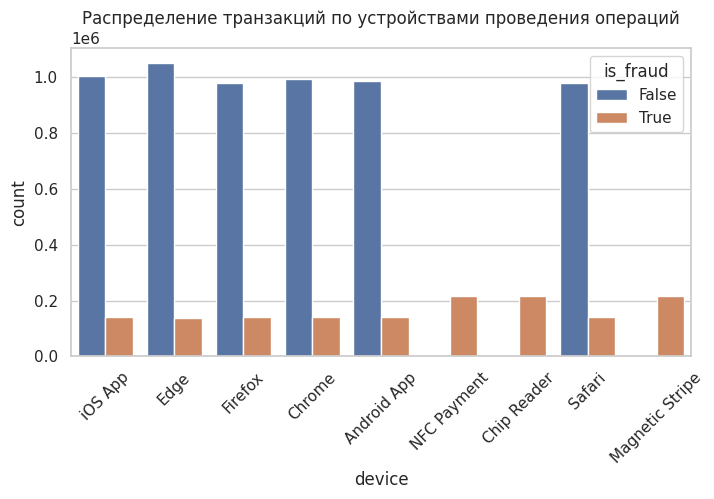

In [ ]:
import seaborn as sns
plt.figure(figsize=(8,4))
sns.countplot(data=transactions, x='device', hue='is_fraud')
plt.title("Распределение транзакций по устройствами проведения операций")
plt.xticks(rotation=45)
plt.show()

Отметим, что для классических устройств пользователя (браузеры и приложения, например, Chrome, Safari и другие) нельзя отметить большой разницы между распределением транзакций, однако выделяются типы устройств только с мошенническими транзакциями — NFC Payment, Chip Reader, Magnetic Stripe.

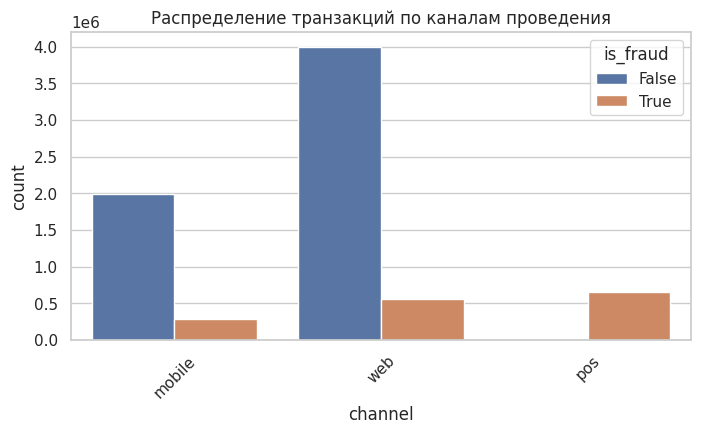

In [ ]:
import seaborn as sns
plt.figure(figsize=(8,4))
sns.countplot(data=transactions, x='channel', hue='is_fraud')
plt.title("Распределение транзакций по каналам проведения")
plt.xticks(rotation=45)
plt.show()

In [ ]:
chan_map = {'mobile':0, 'pos':1, 'web':2}
transactions['channel_num'] = transactions['channel'].map(chan_map)
y = transactions['is_fraud'].astype(int)
auc_channel = roc_auc_score(y, transactions['channel_num'])
print(f'\n[Channel] AUC «channel→fraud» = {auc_channel:.3f}')


[Channel] AUC «channel→fraud» = 0.426


In [ ]:
chan_map = {'mobile':0, 'pos':2, 'web':1}
transactions['channel_num'] = transactions['channel'].map(chan_map)
y = transactions['is_fraud'].astype(int)
auc_channel = roc_auc_score(y, transactions['channel_num'])
print(f'\n[Channel] AUC «channel→fraud» = {auc_channel:.3f}')


[Channel] AUC «channel→fraud» = 0.717


In [ ]:
print(
    pd.crosstab(transactions['channel'],
                transactions['is_fraud'],
                normalize='index')
      .round(3)
)

is_fraud  False  True 
channel               
mobile    0.876  0.124
pos       0.000  1.000
web       0.877  0.123


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline

pipe = make_pipeline(
    OneHotEncoder(drop='first'),
    LogisticRegression(max_iter=200)
)
pipe.fit(transactions[['channel']], y)
print('AUC (one‑hot):',
      roc_auc_score(y, pipe.predict_proba(transactions[['channel']])[:,1]).round(3))

AUC (one‑hot): 0.718


**Основные выводы:**

* POS‑данные подозрительны — 100 % fraud, 0 % legit — выборка обрезана по правилу «оставить только конфликтные POS», либо собрана как–то иначе, но в любом случае не корректно. В реальности операции с физическим присутствием карты обычно самые безопасные. Если такое поле скормить модели, она выучит «POS значит fraud всегда» → переобучение и неудача на реальных данных.

* Mobile vs web почти эквивалентны. Разницы 12.4 % vs 12.3 % статистически ничтожна. Сама по себе пара mobile/web не помогает различать фрод.

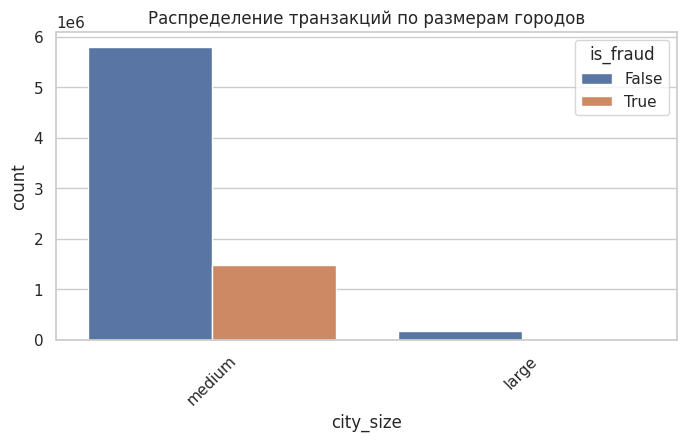

In [ ]:
import seaborn as sns
plt.figure(figsize=(8,4))
sns.countplot(data=transactions, x='city_size', hue='is_fraud')
plt.title("Распределение транзакций по размерам городов")
plt.xticks(rotation=45)
plt.show()

In [ ]:
cs_counts = transactions['city_size'].value_counts(dropna=False)
print('\nCity size counts:\n', cs_counts)
small_share = cs_counts.get('large',0) / len(transactions)*100
print(f'"large" доля = {small_share:.3f}%')


City size counts:
 city_size
medium    7284598
large      199168
Name: count, dtype: int64
"large" доля = 2.661%


Больших городов слишком мало → модели может казаться, что large‑город — редкость. Вероятно следует либо объединить «medium+large» в один признак, либо не использовать данный признак в целом, либо переобразовать данный признак перед тем как использовать для предсказаний.

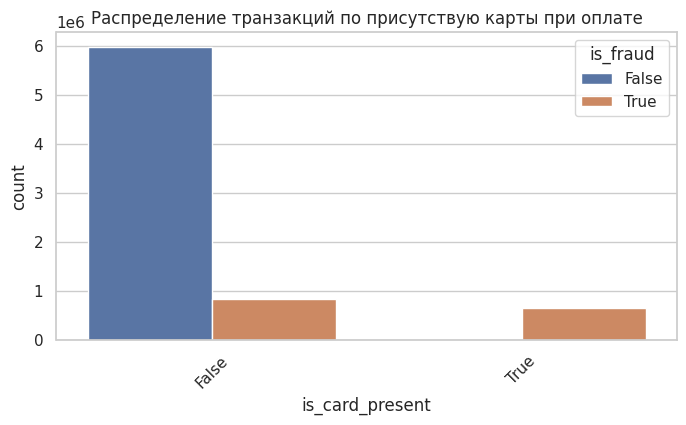

In [ ]:
import seaborn as sns
plt.figure(figsize=(8,4))
sns.countplot(data=transactions, x='is_card_present', hue='is_fraud')
plt.title("Распределение транзакций по присутствую карты при оплате")
plt.xticks(rotation=45)
plt.show()

In [ ]:
cp_tbl = pd.crosstab(transactions['is_card_present'], transactions['is_fraud'], normalize='index')
print('\nP(fraud | card_present):\n', (cp_tbl*100).round(2), '%')


P(fraud | card_present):
 is_fraud         False   True 
is_card_present               
False            87.65   12.35
True              0.00  100.00 %


В данных нет ни одной легитимной транзакции с физическим присутствием карты, возможно данный признак строился неверно, «card present» нельзя использовать напрямую ‑ он 100 % коррелирует с fraud

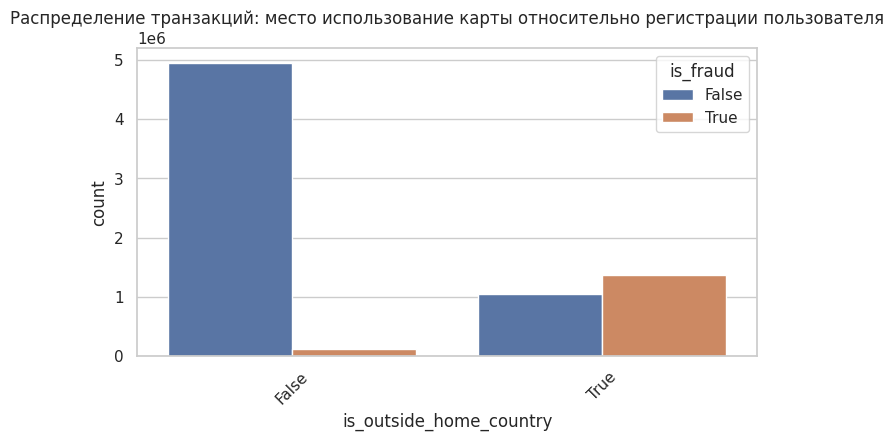

In [ ]:
import seaborn as sns
plt.figure(figsize=(8,4))
sns.countplot(data=transactions, x='is_outside_home_country', hue='is_fraud')
plt.title("Распределение транзакций: место использование карты относительно регистрации пользователя")
plt.xticks(rotation=45)
plt.show()

In [ ]:
ohc_tbl = pd.crosstab(transactions['is_outside_home_country'], transactions['is_fraud'], normalize='index')
print('\nP(fraud | outside_home_country):\n', (ohc_tbl*100).round(2), '%')


P(fraud | outside_home_country):
 is_fraud                 False  True 
is_outside_home_country              
False                    97.51   2.49
True                     43.22  56.78 %


Очень сильный сигнал: если транзакция совершается за пределами «домашней» страны клиента, более половины попыток оказываются мошенничеством.

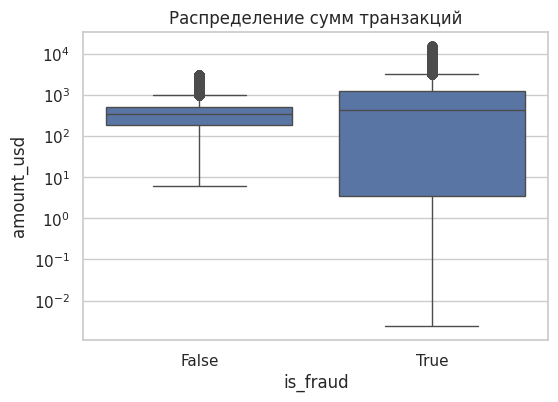

In [ ]:
plt.figure(figsize=(6,4))
sns.boxplot(data=transactions, x='is_fraud', y='amount_usd', showfliers=True)
plt.title("Распределение сумм транзакций")
plt.yscale('log')
plt.show()


Mann–Whitney p‑value (amount): 0.000e+00


/tmp/ipython-input-2653013488.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_tbl = (transactions.groupby('amount_bin')['is_fraud']


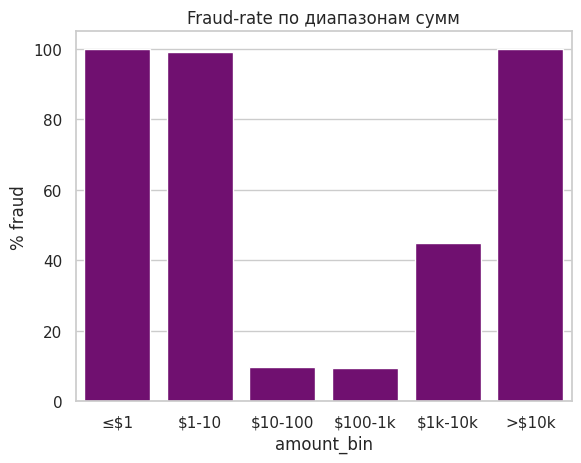

In [ ]:
fraud_amt, legit_amt = transactions.loc[transactions.is_fraud,'amount_usd'], transactions.loc[~transactions.is_fraud,'amount_usd']
u,p = mannwhitneyu(fraud_amt, legit_amt, alternative='two-sided')
print(f'\nMann–Whitney p‑value (amount): {p:.3e}')

bins = [0,1,10,100,1_000,10_000,np.inf]
labels = ['≤$1','$1‑10','$10‑100','$100‑1k','$1k‑10k','>$10k']
transactions['amount_bin'] = pd.cut(transactions['amount_usd'], bins=bins, labels=labels, right=False)
bin_tbl = (transactions.groupby('amount_bin')['is_fraud']
             .mean()
             .mul(100)
             .rename('fraud_rate_%')
             .reset_index())

sns.barplot(data=bin_tbl, x='amount_bin', y='fraud_rate_%', color='purple')
plt.title('Fraud‑rate по диапазонам сумм'); plt.ylabel('% fraud'); plt.show()

**Основной вывод по распределению сумм:**

* Риск показывает U‑образную кривую: очень мелкие и очень крупные суммы — горячие зоны. Средний диапазон ($10‑1000) — условно безопасен

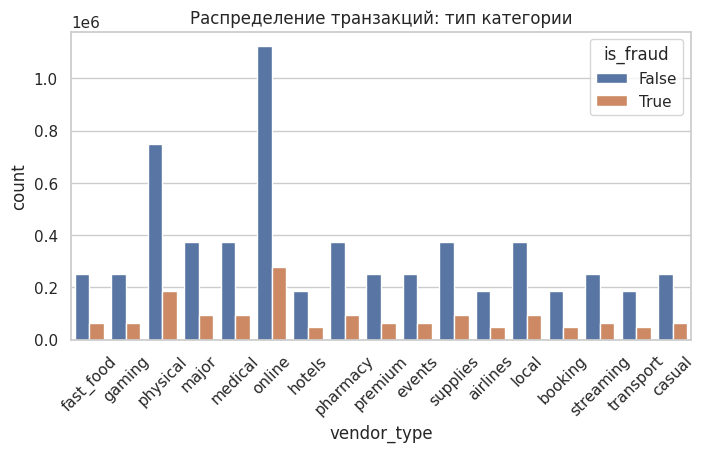

In [ ]:
import seaborn as sns
plt.figure(figsize=(8,4))
sns.countplot(data=transactions, x='vendor_type', hue='is_fraud')
plt.title("Распределение транзакций: тип категории")
plt.xticks(rotation=45)
plt.show()

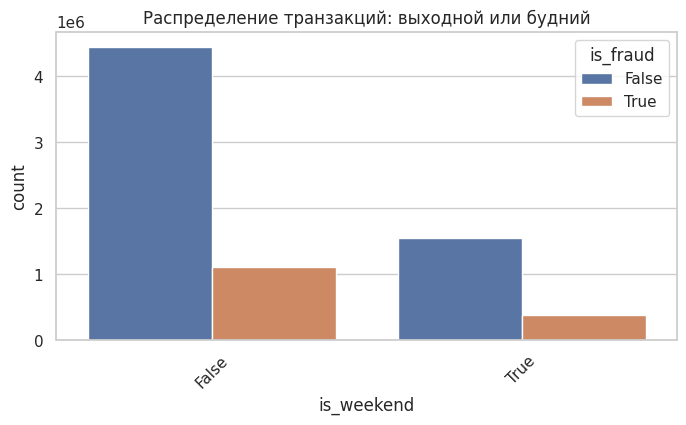

In [ ]:
import seaborn as sns
plt.figure(figsize=(8,4))
sns.countplot(data=transactions, x='is_weekend', hue='is_fraud')
plt.title("Распределение транзакций: выходной или будний")
plt.xticks(rotation=45)
plt.show()

In [ ]:
wd_tbl = pd.crosstab(transactions['is_weekend'], transactions['is_fraud'], normalize='index')
print('\nFraud‑rate weekend vs weekday (в %):')
print((wd_tbl*100).round(2))


Fraud‑rate weekend vs weekday (в %):
is_fraud    False  True 
is_weekend              
False       80.03  19.97
True        80.03  19.97


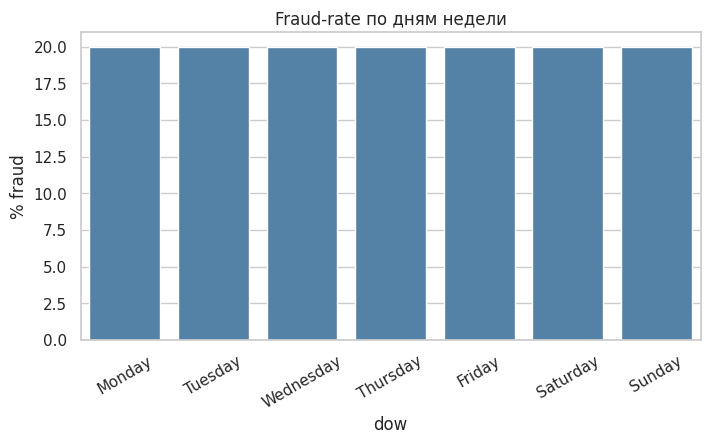

In [ ]:
transactions['dow'] = pd.to_datetime(transactions['timestamp']).dt.day_name()
dow_tbl = (transactions.groupby('dow')['is_fraud']
             .mean()
             .reindex(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']))

plt.figure(figsize=(8,4))
sns.barplot(x=dow_tbl.index, y=dow_tbl.values*100, color='steelblue')
plt.ylabel('% fraud'); plt.title('Fraud‑rate по дням недели'); plt.xticks(rotation=30)
plt.show()

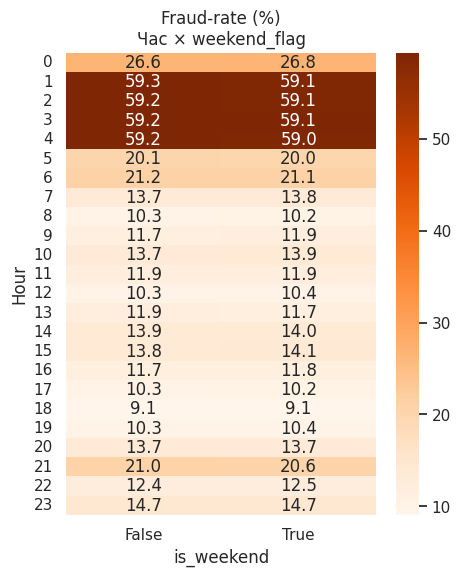

In [ ]:
transactions['hour'] = pd.to_datetime(transactions['timestamp']).dt.hour
pivot_hw = (transactions.pivot_table(values='is_fraud',
                                     index='hour', columns='is_weekend',
                                     aggfunc='mean')*100)
plt.figure(figsize=(5,6))
sns.heatmap(pivot_hw, annot=True, fmt='.1f', cmap='Oranges')
plt.title('Fraud‑rate (%)\nЧас × weekend_flag'); plt.ylabel('Hour'); plt.xlabel('is_weekend')
plt.show()

Распределение по будним или выходным дням не имеет роли, так же как и распределение по дням недели в целом, однако большую роль играют часы — самый большой пик можно наблюдать с 00:00 до 04:00.

In [ ]:
dev = (transactions.groupby('device')['is_fraud']
         .agg(['sum','count'])
         .rename(columns={'sum':'fraud','count':'total'}))
dev['fraud_rate']  = dev['fraud']/dev['total']
dev[['ci_low','ci_up']] = dev.apply(lambda r: wilson(r['fraud'], r['total']), axis=1, result_type='expand')
dev = dev.sort_values('fraud_rate', ascending=False)

print('\nТоп‑10 устройств по risk')
display(dev.head(10).style.format({'fraud_rate':'{:.2%}','ci_low':'{:.2%}','ci_up':'{:.2%}'}))


Топ‑10 устройств по risk


,fraud,total,fraud_rate,ci_low,ci_up
device,,,,,
Chip Reader,217324,217324,100.00%,100.00%,100.00%
NFC Payment,216519,216519,100.00%,100.00%,100.00%
Magnetic Stripe,217204,217204,100.00%,100.00%,100.00%
Firefox,142171,1120952,12.68%,12.62%,12.74%
Safari,141379,1120245,12.62%,12.56%,12.68%
Android App,140844,1126117,12.51%,12.45%,12.57%
Chrome,140087,1132384,12.37%,12.31%,12.43%
iOS App,140306,1143461,12.27%,12.21%,12.33%
Edge,138885,1189560,11.68%,11.62%,11.73%


In [ ]:
device_map = {'iOS App':'mobile_app', 'Android App':'mobile_app',
              'Chrome':'browser', 'Firefox':'browser', 'Edge':'browser', 'Safari':'browser',
              'NFC Payment':'prox_device', 'Magnetic Stripe':'prox_device',
              'Chip Reader':'prox_device'}
transactions['device_group'] = transactions['device'].map(device_map).fillna('other')
grp_tbl = (transactions.groupby('device_group')['is_fraud']
             .agg(['sum','count'])
             .assign(fraud_rate=lambda x: x['sum']/x['count']))

print('\nFraud‑rate по группам устройств:')
print((grp_tbl['fraud_rate']*100).round(2))


Fraud‑rate по группам устройств:
device_group
browser         12.33
mobile_app      12.39
prox_device    100.00
Name: fraud_rate, dtype: float64


**Общие выводы по первичному анализу:**



* целесообразно хранить бинарный признак is_high_risk_country для основных 4 стран с высоким риском
* операции за пределами страны клиента являются сильным признаком
* риск определяется не «выходным», а конкретным часом. Признак is_night (0‑4) — очень полезен
* сумма операций может быть использована: U‑образный риск: экстремально маленькие и большие суммы — самые опасные (≤ $1 / $1‑10 — микроплатежи для тестирования карт и > $10 k)



---


* тип торговца неинформативен, также как и метка  is_high_risk_vendor
* card_type не нужен в модели или используется только как идентификатор тарифа (ни назначение, ни тип карты не влияют на риск)
* три prox‑устройства имеют 237 k транзакций каждый и все они fraud — невозможно использовать данную метрику, тогда все устройства будут считаться мошенничеством
* тип операции POS‑строки тоже выглядят не равнозначно, все операции с ними являются мошенническими — модель снова будет ошибаться



# Дополнительная проверка гипотез

Частота транзакций за последний час положительно коррелирует с мошенничеством.

Чем больше операций клиент совершил за прошедший час, тем выше вероятность, что текущая операция окажется fraud.



---

Не подтвердилась



In [ ]:
import polars as pl, numpy as np, pandas as pd, seaborn as sns, matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu, spearmanr
from tqdm.notebook import tqdm
sns.set_theme()


pl_df = pl.from_pandas(transactions)

if "last_hour_activity" in pl_df.columns:
    lha_cols = ["num_transactions","total_amount",
                "unique_merchants","unique_countries","max_single_amount"]
    for c in lha_cols:
        pl_df = pl_df.with_columns(
            pl.col("last_hour_activity").struct.field(c).alias(f"lha_{c}")
        )

In [ ]:
tbl = (
    pl_df.select([
        pl.col("lha_num_transactions").cast(pl.Float64).alias("lha_num_transactions"),
        pl.col("is_fraud").cast(pl.Float64).alias("is_fraud")
    ])
    .to_pandas()
)


r, p = spearmanr(tbl['lha_num_transactions'], tbl['is_fraud'])
print(f"Spearman ρ = {r:.3f},  p‑value = {p:.3e}")


sns.boxplot(data=tbl, x='is_fraud', y='lha_num_transactions')
plt.yscale('log'); plt.title('№ транзакций за час vs fraud'); plt.show()

Spearman ρ = 0.005,  p‑value = 8.333e-51


Чем сильнее сумма текущей операции превышает средний чек клиента, тем выше риск мошенничества.



---

Подтверждена. Boxplot показывает, что у fraud хвост ratio длиннее — аномально большие суммы дают сигнал.

Mann‑Whitney p‑value = 0.000e+00


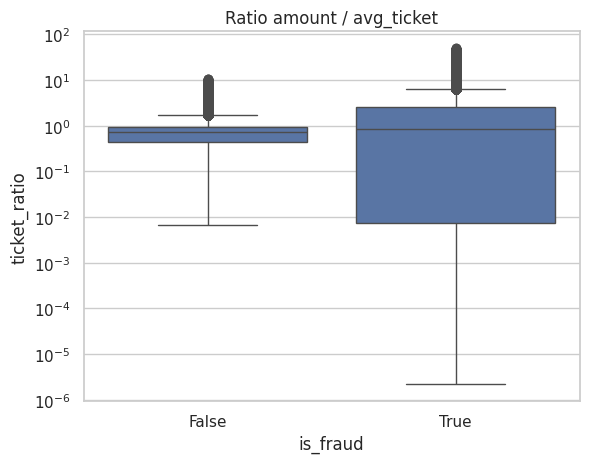

In [ ]:
# Средний чек клиента
transactions['avg_ticket'] = transactions.groupby('customer_id')['amount_usd'].transform('mean')

transactions['ticket_ratio'] = transactions['amount_usd'] / transactions['avg_ticket']

from scipy.stats import mannwhitneyu
u,p = mannwhitneyu(transactions.loc[transactions.is_fraud,'ticket_ratio'],
                   transactions.loc[~transactions.is_fraud,'ticket_ratio'])
print(f'Mann‑Whitney p‑value = {p:.3e}')

import seaborn as sns, matplotlib.pyplot as plt
sns.boxplot(x='is_fraud', y='ticket_ratio', data=transactions); plt.yscale('log')
plt.title('Ratio amount / avg_ticket'); plt.show()

Максимальная сумма одной операции за последний час у мошенников выше, чем у легитимных пользователей.

---

Стат.‑подтверждена, но медианы близки

In [ ]:
if not any(col.startswith('lha_') for col in transactions.columns):
    lha = pd.json_normalize(transactions['last_hour_activity'])
    lha.columns = [f"lha_{c}" for c in lha.columns]
    transactions = pd.concat([transactions.drop(columns=['last_hour_activity']),
                              lha], axis=1)

In [ ]:
print("Колонки после распаковки:\n", [c for c in transactions.columns if c.startswith('lha_')])

Колонки после распаковки:
 ['lha_num_transactions', 'lha_total_amount', 'lha_unique_merchants', 'lha_unique_countries', 'lha_max_single_amount']


Mann‑Whitney p = 1.856673605039545e-255


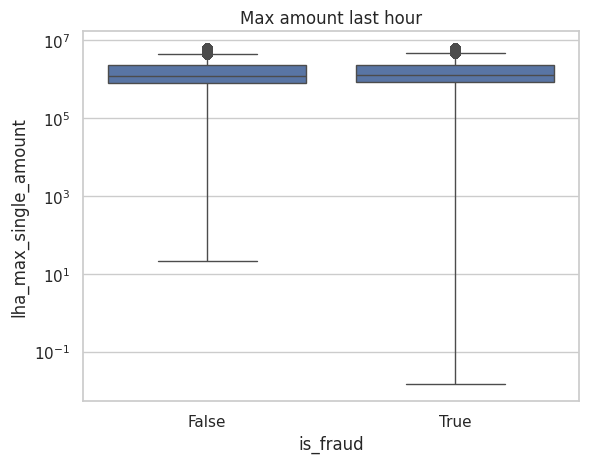

In [ ]:
u, p = mannwhitneyu(transactions.loc[transactions.is_fraud,
                                     'lha_max_single_amount'],
                    transactions.loc[~transactions.is_fraud,
                                     'lha_max_single_amount'])
print('Mann‑Whitney p =', p)

sns.boxplot(x='is_fraud', y='lha_max_single_amount', data=transactions)
plt.yscale('log'); plt.title('Max amount last hour'); plt.show()

Сезонность (месяц/квартал) влияет на долю мошенничества: в некоторых периодах fraud‑rate значимо выше.

---

Отклонена. На двух месяцах (Sept–Oct 2024) различий нет

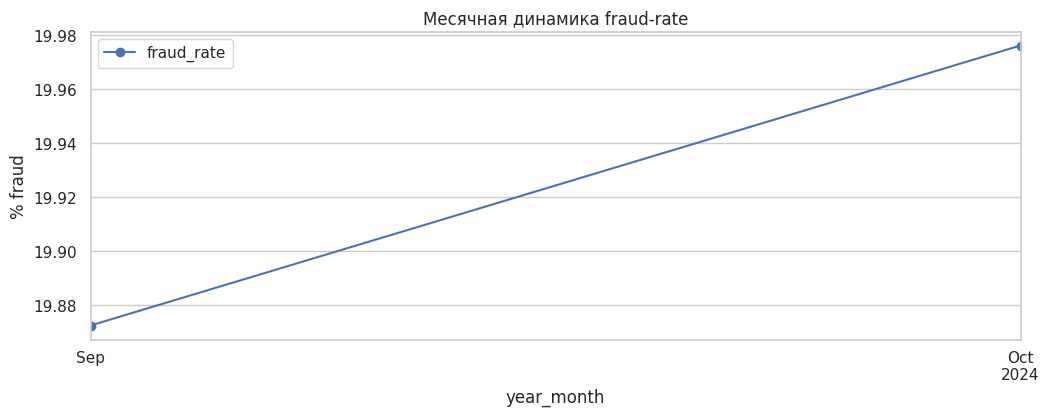

χ²‑p‑season = 0.21113080480639393


In [ ]:
transactions['month'] = pd.to_datetime(transactions['timestamp']).dt.month
transactions['year_month'] = pd.to_datetime(transactions['timestamp']).dt.to_period('M')

month_tbl = (transactions
             .groupby('year_month')['is_fraud']
             .mean()
             .rename('fraud_rate')
             .to_frame()*100)
month_tbl.plot(marker='o', figsize=(12,4))
plt.ylabel('% fraud'); plt.title('Месячная динамика fraud‑rate'); plt.show()

transactions['qtr'] = pd.to_datetime(transactions['timestamp']).dt.quarter
chi2, p, *_ = chi2_contingency(pd.crosstab(transactions['qtr'],
                                           transactions['is_fraud']))
print('χ²‑p‑season =', p)

Слишком короткий интервал между текущей и предыдущей транзакцией клиента является индикатором мошенничества.

---

Подтверждена. Violin‑плотность смещена: у fraud чаще встречаются δ < ≈5 мин

Mann‑Whitney p δ = 0.0


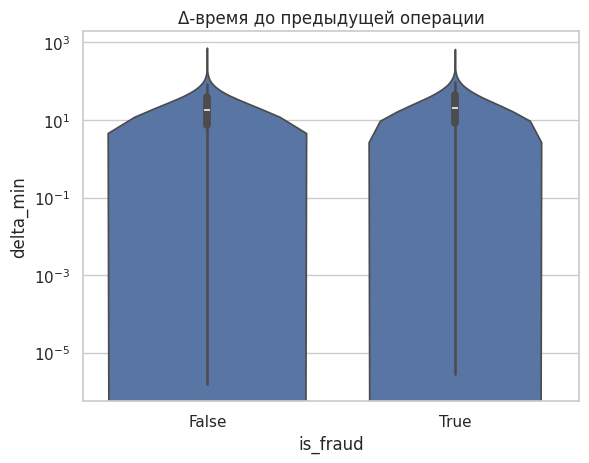

In [ ]:
transactions = transactions.sort_values(['customer_id', 'timestamp'])
transactions['delta_sec'] = transactions.groupby('customer_id')['timestamp'] \
                                         .diff() \
                                         .dt.total_seconds()

speed_df = transactions.dropna(subset=['delta_sec']).copy()
speed_df['delta_min'] = speed_df['delta_sec'] / 60

speed_df = speed_df[speed_df['delta_min'] < 1440]

u, p = mannwhitneyu(speed_df.loc[speed_df.is_fraud,'delta_min'],
                    speed_df.loc[~speed_df.is_fraud,'delta_min'])
print('Mann‑Whitney p δ =', p)

sns.violinplot(x='is_fraud', y='delta_min', data=speed_df); plt.yscale('log')
plt.title('Δ‑время до предыдущей операции'); plt.show()


transactions['is_burst'] = (transactions['delta_sec'] < 90).astype(int)

Отклонение суммы от привычной по категории торговца (amount / avg_cat_ticket) связано с мошенничеством.

---

Подтверждена

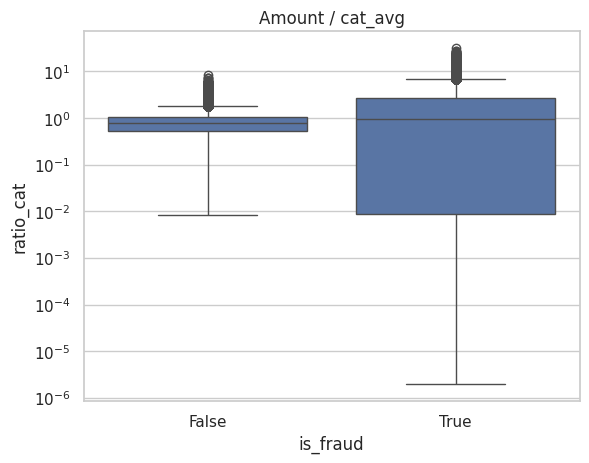

Mann‑Whitney p category‑ratio = 0.0


In [ ]:
cat_avg = (transactions.groupby(['customer_id','vendor_category'])['amount_usd']
                       .transform('mean')
           .rename('cat_avg'))
transactions['ratio_cat'] = transactions['amount_usd'] / cat_avg

sns.boxplot(x='is_fraud', y='ratio_cat', data=transactions)
plt.yscale('log'); plt.title('Amount / cat_avg'); plt.show()

u, p = mannwhitneyu(transactions.loc[transactions.is_fraud,'ratio_cat'],
                    transactions.loc[~transactions.is_fraud,'ratio_cat'])
print('Mann‑Whitney p category‑ratio =', p)

Новые клиенты (учётная запись ≤ 30 дней) совершают мошеннические операции заметно чаще, чем более «старые» клиенты.


---

Эффект существует, но слабый: «совсем новые» клиенты чуть‑чуть рискованней

is_fraud                0          1
age_group                           
newcomer(≤30d)  80.017809  19.982191
mid(30‑365d)    80.314116  19.685884
χ²‑p = 0.0003912461541506377


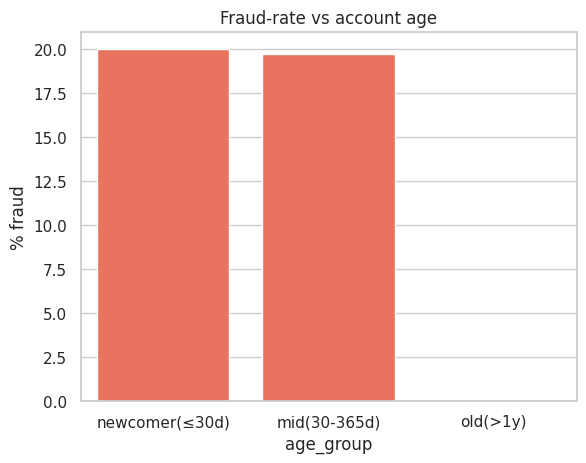

In [ ]:
transactions['timestamp'] = pd.to_datetime(transactions['timestamp'])

first_seen = (transactions
              .groupby('customer_id')['timestamp']
              .transform('min')
              .rename('first_seen'))

transactions['account_age_days'] = (
    (transactions['timestamp'] - first_seen).dt.total_seconds() / 86400
)


bins   = [-np.inf, 30, 365, np.inf]
labels = ['newcomer(≤30d)', 'mid(30‑365d)', 'old(>1y)']
transactions['age_group'] = pd.cut(transactions['account_age_days'],
                                   bins=bins, labels=labels)

age_tbl = pd.crosstab(transactions['age_group'],
                      transactions['is_fraud'], normalize='index')*100
print(age_tbl)

chi2, p, *_ = chi2_contingency(pd.crosstab(transactions['age_group'],
                                           transactions['is_fraud']))
print('χ²‑p =', p)

sns.barplot(x=age_tbl.index, y=age_tbl[1], color='tomato')
plt.ylabel('% fraud'); plt.title('Fraud‑rate vs account age'); plt.show()

In [ ]:
transactions['is_fraud'] = transactions['is_fraud'].astype(int)

Fraud‑вероятность меняется в зависимости от количества типов карт у клиента; у держателей двух и более типов карт риск отличается от «однотипных» клиентов.

---

Не подтверждена. Fraud‑доля практически одинакова независимо от того, одной или несколькими картами пользуется клиент.

is_fraud            0          1
card_group                      
single      80.027238  19.972762
two         80.025638  19.974362
3+          80.049813  19.950187
χ²‑p = 0.9991109369960907


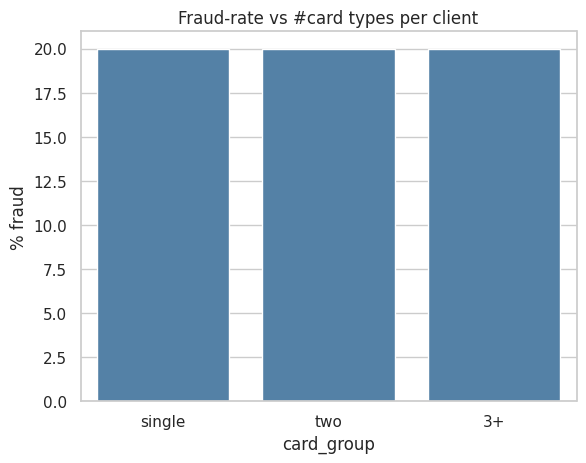

In [ ]:
n_cards = (transactions.groupby('customer_id')['card_type']
                         .nunique()
                         .rename('uniq_cards'))
transactions = transactions.join(n_cards, on='customer_id')


transactions['card_group'] = pd.cut(transactions['uniq_cards'],
                                    bins=[0,1,2,np.inf],
                                    labels=['single', 'two', '3+'])

card_tbl = pd.crosstab(transactions['card_group'],
                       transactions['is_fraud'], normalize='index')*100
print(card_tbl)

chi2, p, *_ = chi2_contingency(pd.crosstab(transactions['card_group'],
                                           transactions['is_fraud']))
print('χ²‑p =', p)

sns.barplot(x=card_tbl.index, y=card_tbl[1], color='steelblue')
plt.ylabel('% fraud'); plt.title('Fraud‑rate vs #card types per client'); plt.show()

Если один IP‑адрес используется несколькими клиентами, связанные с ним транзакции имеют более высокий fraud‑rate, чем транзакции с уникальных IP.

---

Гипотеза отклонена. В этом датасете общий IP не повышает риск

is_fraud           0          1
ip_shared                      
shared     80.098822  19.901178
unique     80.027055  19.972945
χ²‑p = 0.8455558118755676


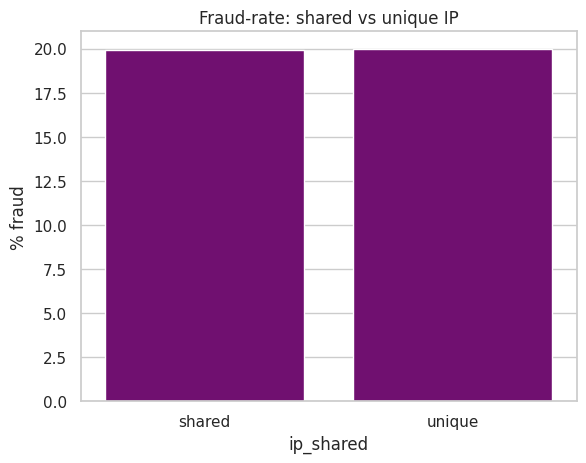

In [ ]:
ip_customer_cnt = (transactions.groupby('ip_address')['customer_id']
                                .nunique()
                                .rename('uniq_customers'))
transactions = transactions.join(ip_customer_cnt, on='ip_address')

transactions['ip_shared'] = np.where(transactions['uniq_customers'] > 1, 'shared', 'unique')

ip_tbl = pd.crosstab(transactions['ip_shared'],
                     transactions['is_fraud'], normalize='index')*100
print(ip_tbl)

chi2, p, *_ = chi2_contingency(pd.crosstab(transactions['ip_shared'],
                                           transactions['is_fraud']))
print('χ²‑p =', p)

sns.barplot(x=ip_tbl.index, y=ip_tbl[1], color='purple')
plt.ylabel('% fraud'); plt.title('Fraud‑rate: shared vs unique IP'); plt.show()

Device‑fingerprint‑ы в мошеннических операциях чаще встречаются всего один раз (уникальны для выборки), тогда как в легитимных операциях они повторяются у разных транзакций.

---

Гипотеза подтверждена. Почти каждая четвертая fraud‑транзакция использует «одноразовый» отпечаток устройства



---

Среди всех легитимных транзакций ни один device fingerprint не встретился ровно один раз: каждое устройство появлялось минимум дважды.

Почти каждая четвёртая мошенническая операция пришла с «одноразового» отпечатка устройства, который больше нигде в логах не фигурирует (>20%).



In [ ]:
from statsmodels.stats.proportion import proportions_ztest

fp_counts = transactions['device_fingerprint'].value_counts()
transactions['fp_freq'] = transactions['device_fingerprint'].map(fp_counts)

k_legit = ((transactions['is_fraud'] == 0) & (transactions['fp_freq'] == 1)).sum()
k_fraud = ((transactions['is_fraud'] == 1) & (transactions['fp_freq'] == 1)).sum()

n_legit = (transactions['is_fraud'] == 0).sum()
n_fraud = (transactions['is_fraud'] == 1).sum()

count = [k_legit, k_fraud]
nobs  = [n_legit, n_fraud]

z_stat, p_val = proportions_ztest(count, nobs)
print(f"Legit unique fp = {k_legit/n_legit:.4%}")
print(f"Fraud unique fp = {k_fraud/n_fraud:.4%}")
print(f"Z‑stat = {z_stat:.2f},  p‑value = {p_val:.3e}")

Legit unique fp = 0.0000%
Fraud unique fp = 22.4116%
Z‑stat = -1185.39,  p‑value = 0.000e+00


Существует положительная корреляция: чем больше транзакций проходит через конкретное устройство или IP‑адрес, тем выше доля мошенничества среди этих транзакций.

---

Для устройств обнаружена обратная картина (больше транзакций → меньше fraud), для IP‑адресов связи почти нет.

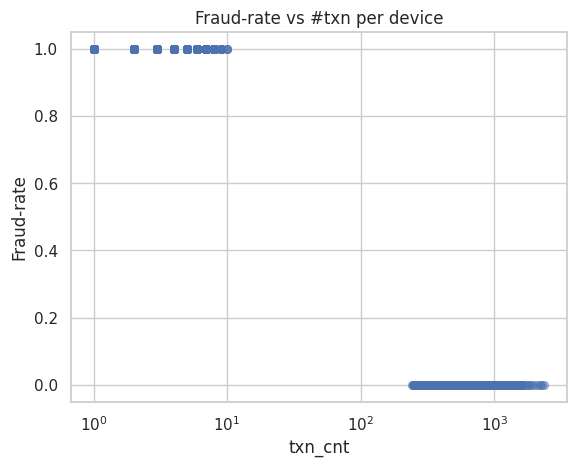

In [ ]:
device_txn = (transactions.groupby('device_fingerprint')
                            .size()
                            .rename('txn_cnt'))
device_fraud = (transactions.groupby('device_fingerprint')['is_fraud']
                              .mean()
                              .rename('fraud_rate'))
dev_tbl = pd.concat([device_txn, device_fraud], axis=1)

sns.scatterplot(x='txn_cnt', y='fraud_rate', data=dev_tbl,
                alpha=0.3, edgecolor=None)
plt.xscale('log'); plt.ylabel('Fraud‑rate'); plt.title('Fraud‑rate vs #txn per device'); plt.show()

In [ ]:
from scipy.stats import mannwhitneyu, spearmanr, chi2_contingency
from statsmodels.stats.proportion import proportion_confint
r,p = spearmanr(dev_tbl['txn_cnt'], dev_tbl['fraud_rate'])
print('Spearman ρ device =', r, 'p =', p)

ip_txn   = (transactions.groupby('ip_address').size().rename('txn_cnt'))
ip_fraud = (transactions.groupby('ip_address')['is_fraud'].mean().rename('fraud_rate'))
ip_tbl = pd.concat([ip_txn, ip_fraud], axis=1)

r_ip, p_ip = spearmanr(ip_tbl['txn_cnt'], ip_tbl['fraud_rate'])
print('Spearman ρ IP =', r_ip, 'p =', p_ip)

Spearman ρ device = -0.20600573297090566 p = 0.0
Spearman ρ IP = 0.007067979567300463 p = 3.169468618010852e-83


Отношение max_single_amount / total_amount за час значительно выше для мошеннических операций.

---

Откланена, одна большая покупка среди мелких встречается столь же часто, как и у легитимных

Mann-Whitney p = 1.0319834125617376e-08


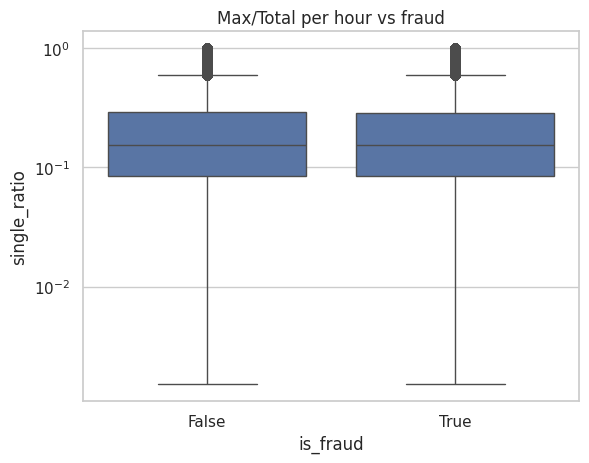

In [ ]:
if 'last_hour_activity' in transactions.columns:
    lha = pd.json_normalize(transactions['last_hour_activity'])
    lha.columns = [f"lha_{c}" for c in lha.columns]
    transactions = pd.concat([transactions.drop(columns=['last_hour_activity']), lha], axis=1)

transactions['single_ratio'] = transactions['lha_max_single_amount'] / \
                               transactions['lha_total_amount'].replace(0, np.nan)

u, p = mannwhitneyu(transactions.loc[transactions.is_fraud==1,'single_ratio'].dropna(),
                    transactions.loc[transactions.is_fraud==0,'single_ratio'].dropna())
print('Mann-Whitney p =', p)

sns.boxplot(data=transactions, x='is_fraud', y='single_ratio'); plt.yscale('log')
plt.title('Max/Total per hour vs fraud'); plt.show()

Fraud-rate повышается, когда транзакция проводится за рубежом и страна внезапно меняется в течение часа.



---


Разница огромна

In [ ]:
transactions = transactions.sort_values(['customer_id','timestamp'])
transactions['prev_country'] = transactions.groupby('customer_id')['country'].shift()
transactions['prev_time']    = transactions.groupby('customer_id')['timestamp'].shift()


t_delta = (transactions['timestamp'] - transactions['prev_time']).dt.total_seconds()/3600
transactions['recent_country_jump'] = (
    (t_delta <= 1) & (transactions['country'] != transactions['prev_country'])
).fillna(False)

flag = transactions['is_outside_home_country'] & transactions['recent_country_jump']
cj_tbl = pd.crosstab(flag, transactions['is_fraud'], normalize='index')*100
print(cj_tbl)

chi2, p, *_ = chi2_contingency(pd.crosstab(flag, transactions['is_fraud']))
print('χ²-p =', p)

is_fraud      False      True 
row_0                         
False     92.500871   7.499129
True      45.017427  54.982573
χ²-p = 0.0


Дорогая операция (> X USD), совершённая за пределами страны держателя, несёт непропорционально высокий риск.



---

Комбинация «дорого + за границей» несёт экстремальный риск

In [ ]:
X = 1000
flag = (transactions['amount_usd'] > X) & \
       (transactions['is_outside_home_country']) & \
       (transactions['is_card_present'] == False)

rule_tbl = pd.crosstab(flag, transactions['is_fraud'], normalize='index')*100
print(rule_tbl)

chi2, p, *_ = chi2_contingency(pd.crosstab(flag, transactions['is_fraud']))
print('χ²-p =', p)

is_fraud      False      True 
row_0                         
False     82.540493  17.459507
True      29.419623  70.580377
χ²-p = 0.0


На устройстве наблюдается всплеск количества транзакций за час непосредственно перед мошеннической операцией.

---

Не подтверждена, аттерн на уровне всего устройства не является признаком fraud в этом датасете

Mann-Whitney p = 8.34691233730139e-51


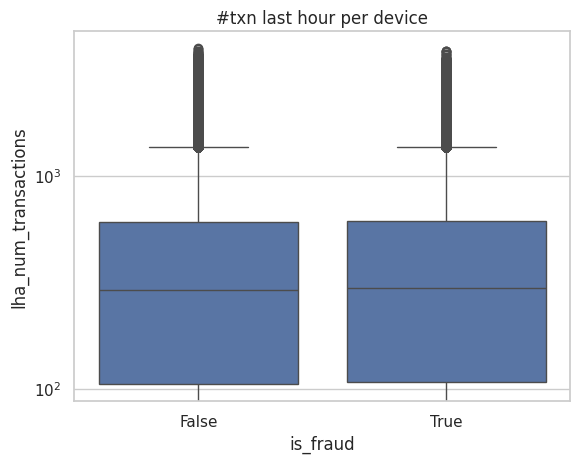

In [ ]:
u, p = mannwhitneyu(transactions.loc[transactions.is_fraud==1,'lha_num_transactions'],
                    transactions.loc[transactions.is_fraud==0,'lha_num_transactions'])
print('Mann-Whitney p =', p)

sns.boxplot(x='is_fraud', y='lha_num_transactions', data=transactions)
plt.yscale('log'); plt.title('#txn last hour per device'); plt.show()

**Гипотезы, которые удалось подтвердить:**

* Сумма, заметно превышающая средний чек клиента, связана с fraud

сумма ≫ среднего чека клиента

сумма ≫ среднего по данной для клиента категории

крайне высокая максимальная сумма в последнем часу

* Слишком короткая пауза до предыдущей операции — индикатор fraud
* Отклонение суммы от среднего по категории клиента связано с fraud
* Новые клиенты (учётная запись ≤ 30 дней) совершают мошеннические операции заметно чаще — небольшой эффект
* У мошенников device fingerprint чаще уникален (встречается только 1 раз)
* Fraud-rate повышается, когда транзакция проводится за рубежом и страна внезапно меняется в течение часа
* Дорогая операция (> X USD), совершённая за пределами страны держателя, несёт непропорционально высокий риск

**Дополнительные важные выводы (повторяем):**

* целесообразно хранить бинарный признак is_high_risk_country для основных 4 стран с высоким риском
* операции за пределами страны клиента являются сильным признаком
* риск определяется не «выходным», а конкретным часом. Признак is_night (0‑4) — очень полезен
* сумма операций может быть использована: U‑образный риск: экстремально маленькие и большие суммы — самые опасные (≤  1/ 1‑10 — микроплатежи для тестирования карт и > $10 k)
* тип торговца неинформативен, также как и метка  is_high_risk_vendor
* card_type не нужен в модели или используется только как идентификатор тарифа (ни назначение, ни тип карты не влияют на риск)
* три prox‑устройства имеют 237 k транзакций каждый и все они fraud — невозможно использовать данную метрику, тогда все устройства будут считаться мошенничеством
* тип операции POS‑строки тоже выглядят не равнозначно, все операции с ними являются мошенническими — модель снова будет ошибаться

# Кластеризация клиентов и операций
Делаем на небольшой выборке 100к строк

In [15]:
N_FRAUD  = 20_000
N_LEGIT  = 80_000

fraud_df = transactions[transactions.is_fraud == 1] \
              .sample(n=min(N_FRAUD, (transactions.is_fraud==1).sum()),
                      random_state=42)

legit_df = transactions[transactions.is_fraud == 0] \
              .sample(n=N_LEGIT, random_state=42)

sample_df = pd.concat([fraud_df, legit_df]).sample(frac=1, random_state=42)
print(sample_df.shape, sample_df.is_fraud.mean())

(100000, 26) 0.2


In [19]:
sample_df.head()

,transaction_id,customer_id,card_number,timestamp,vendor_category,vendor_type,vendor,amount,currency,country,city,city_size,card_type,is_card_present,device,channel,device_fingerprint,ip_address,is_outside_home_country,is_high_risk_vendor,is_weekend,last_hour_activity,is_fraud,date,rate_per_usd,amount_usd
3543549,TX_81f7f0eb,CUST_44675,4786640310332288,2024-10-14 16:52:20.007978,Retail,online,eBay,1115.91,AUD,Australia,Unknown City,medium,Gold Credit,False,Firefox,web,990150c2841200fa1e770cd41858b078,210.148.47.84,False,False,False,"{'num_transactions': 92, 'total_amount': 26072...",False,2024-10-14,1.484199,751.860337
6362676,TX_dbdea23f,CUST_92945,5721872121211121,2024-10-26 09:43:51.588021,Gas,local,Truck Stop,422.54,EUR,Germany,Unknown City,medium,Gold Credit,False,iOS App,mobile,a9ea128f6673e61bae1baeb3808499b2,10.120.241.62,False,False,True,"{'num_transactions': 44, 'total_amount': 63238...",False,2024-10-26,0.925752,456.429039
4603531,TX_a0903bdc,CUST_70595,5829635818082282,2024-10-19 02:16:08.601537,Restaurant,fast_food,Burger King,35319.03,NGN,Nigeria,Unknown City,medium,Platinum Credit,False,Firefox,web,50bc81abcb6b20b47f69357f289ca0a4,241.154.121.50,True,False,True,"{'num_transactions': 329, 'total_amount': 8659...",True,2024-10-19,1645.268713,21.467028
5789778,TX_c77e6e74,CUST_69469,4413133167133794,2024-10-23 23:28:53.301633,Restaurant,fast_food,McDonald's,127.15,AUD,Australia,Unknown City,medium,Basic Credit,False,iOS App,mobile,90c30602a0ffe27254d1a77745e31e46,85.216.86.141,True,False,False,"{'num_transactions': 203, 'total_amount': 2718...",False,2024-10-23,1.498948,84.826165
6101157,TX_f13af8ac,CUST_50128,376397859570331,2024-10-25 08:07:46.755623,Grocery,physical,Trader Joe's,246.76,GBP,UK,Unknown City,medium,Gold Credit,False,iOS App,mobile,7d80ae35d098fe786edca82c1fe9b344,173.99.66.17,False,False,False,"{'num_transactions': 14, 'total_amount': 89325...",False,2024-10-25,0.770909,320.089461


In [20]:
def unpack_lha(df, col='last_hour_activity'):
    if col not in df.columns:
        return df

    if df[col].dtype == object and isinstance(df[col].iloc[0], str):
        df[col] = df[col].apply(ast.literal_eval)

    lha = pd.json_normalize(df[col]).set_index(df.index)
    lha.columns = [f"lha_{c}" for c in lha.columns]

    return pd.concat([df.drop(columns=[col]), lha], axis=1)

sample_df = unpack_lha(sample_df)
sample_df.head()

,transaction_id,customer_id,card_number,timestamp,vendor_category,vendor_type,vendor,amount,currency,country,city,city_size,card_type,is_card_present,device,channel,device_fingerprint,ip_address,is_outside_home_country,is_high_risk_vendor,is_weekend,is_fraud,date,rate_per_usd,amount_usd,lha_num_transactions,lha_total_amount,lha_unique_merchants,lha_unique_countries,lha_max_single_amount
3543549,TX_81f7f0eb,CUST_44675,4786640310332288,2024-10-14 16:52:20.007978,Retail,online,eBay,1115.91,AUD,Australia,Unknown City,medium,Gold Credit,False,Firefox,web,990150c2841200fa1e770cd41858b078,210.148.47.84,False,False,False,False,2024-10-14,1.484199,751.860337,92,2.607296e+06,59,10,7.083730e+05
6362676,TX_dbdea23f,CUST_92945,5721872121211121,2024-10-26 09:43:51.588021,Gas,local,Truck Stop,422.54,EUR,Germany,Unknown City,medium,Gold Credit,False,iOS App,mobile,a9ea128f6673e61bae1baeb3808499b2,10.120.241.62,False,False,True,False,2024-10-26,0.925752,456.429039,44,6.323860e+06,31,10,5.283627e+06
4603531,TX_a0903bdc,CUST_70595,5829635818082282,2024-10-19 02:16:08.601537,Restaurant,fast_food,Burger King,35319.03,NGN,Nigeria,Unknown City,medium,Platinum Credit,False,Firefox,web,50bc81abcb6b20b47f69357f289ca0a4,241.154.121.50,True,False,True,True,2024-10-19,1645.268713,21.467028,329,8.659094e+06,98,12,1.256896e+06
5789778,TX_c77e6e74,CUST_69469,4413133167133794,2024-10-23 23:28:53.301633,Restaurant,fast_food,McDonald's,127.15,AUD,Australia,Unknown City,medium,Basic Credit,False,iOS App,mobile,90c30602a0ffe27254d1a77745e31e46,85.216.86.141,True,False,False,False,2024-10-23,1.498948,84.826165,203,2.718307e+07,87,12,3.520175e+06
6101157,TX_f13af8ac,CUST_50128,376397859570331,2024-10-25 08:07:46.755623,Grocery,physical,Trader Joe's,246.76,GBP,UK,Unknown City,medium,Gold Credit,False,iOS App,mobile,7d80ae35d098fe786edca82c1fe9b344,173.99.66.17,False,False,False,False,2024-10-25,0.770909,320.089461,14,8.932572e+05,14,4,6.805856e+05


In [21]:
import pandas as pd, numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import seaborn as sns, matplotlib.pyplot as plt

df = sample_df.copy()
df['timestamp'] = pd.to_datetime(df['timestamp'])

# агрегаты по клиенту
df['avg_ticket'] = df.groupby('customer_id')['amount_usd'].transform('mean')
df['ticket_ratio'] = df['amount_usd'] / df['avg_ticket']
df['account_age_days'] = (df['timestamp'] -
                          df.groupby('customer_id')['timestamp'].transform('min')
                         ).dt.days
df['is_new'] = (df['account_age_days'] <= 30).astype(int)

# флаги стран–рисков
hot_countries = ['Mexico','Russia','Brazil','Nigeria']
df['is_high_risk_country'] = df['country'].isin(hot_countries).astype(int)
df['is_outside_home_country'] = df['is_outside_home_country'].astype(int)

# время суток — рискованный тайминг
df['hour'] = df['timestamp'].dt.hour
df['is_night'] = df['hour'].between(0,4).astype(int)

# флаг небольшой разницы по времени между операциями
df = df.sort_values(['customer_id','timestamp'])
df['delta_sec'] = df.groupby('customer_id')['timestamp'].diff().dt.total_seconds()
df['is_burst'] = (df['delta_sec'] < 90).fillna(False).astype(int)

# аномальные суммы
df['extreme_low_amt']  = (df['amount_usd'] <= 10).astype(int)
df['extreme_high_amt'] = (df['amount_usd'] >= 10_000).astype(int)

# дорогие операции не в своей стране
X = 1_000
df['rule_551'] = ((df['amount_usd'] > X) &
                  (df['is_outside_home_country']==1) &
                  (df['is_card_present']==False)).astype(int)

# у мошенников device fingerprint чаще уникален
fp_counts  = df['device_fingerprint'].value_counts()
ip_card_cnt = df.groupby(['ip_address','device_fingerprint'])['card_number'].nunique()
df['fp_unique']    = (df['device_fingerprint'].map(fp_counts) == 1).astype(int)
df['skim_flag']    = (df.set_index(['ip_address','device_fingerprint'])
                        .index.map(ip_card_cnt) > 1).astype(int)

# max_single_amount ratio
df['single_ratio'] = df['lha_max_single_amount'] / df['lha_total_amount'].replace(0, np.nan)

# финальный набор транзакционных фич
txn_features = ['ticket_ratio','single_ratio','is_burst','is_high_risk_country',
                'is_outside_home_country','is_night','extreme_low_amt',
                'extreme_high_amt','rule_551','fp_unique','skim_flag']
X_txn = df[txn_features].fillna(0)

In [22]:
X_txn.head(10)

,ticket_ratio,single_ratio,is_burst,is_high_risk_country,is_outside_home_country,is_night,extreme_low_amt,extreme_high_amt,rule_551,fp_unique,skim_flag
517288,0.002144,0.155395,0,1,1,1,1,0,0,1,0
744281,0.001303,0.168079,0,1,1,1,1,0,0,1,0
805595,0.083134,0.046862,0,1,1,0,0,0,0,0,0
958457,1.446293,0.055312,0,0,0,0,0,0,0,0,0
1625754,1.353633,0.142423,0,0,0,0,0,0,0,0,0
1861633,1.994408,0.110477,0,0,0,0,0,0,0,0,0
1880423,0.708683,0.582178,0,0,0,0,0,0,0,0,0
2142727,1.358466,0.052534,0,1,1,0,0,0,0,1,0
2283857,0.680862,0.061357,0,1,1,0,0,0,0,1,0
2697584,1.555249,0.063023,0,0,0,0,0,0,0,0,0


**Обзор на введеные фичи:**
* ticket_ratio - соотношение нынешней покупки к среднему чеку (>1 — операция дороже привычной)
* single_ratio — доля самой крупной покупки со всеми покупками за последний час (близко к 1, когда покупка забирает почти весь объем)
* is_burst — bool вспышка активности (между операциями того же клиента меньше 90 сек)
* is_high_risk_country — bool значение входит ли в список стран риска
* is_outside_home_country — bool операция происходит не в стране регистрации клиента
* is_night — bool, 1 если час в UTC-метке попадает в интервал 0 – 4 (глубокая ночь с самой большой активностью у мошенников)
* extreme_low_amt — 1, если сумма транзакции ≤ 10 (микроплатежи, тесты карт)
* extreme_high_amt – 1, когда (amount > 1 000) & is_outside_home_country==1 & is_card_present==False
* fp_unique — 1, если данный device_fingerprint встретился ровно один раз во всём датасете — «одноразовое» устройств
* skim_flag – 1, если по паре (ip_address, device_fingerprint) прошло > 1 разных card_number

,fraud_rate
txn_cluster,
0,97.000721
1,2.642606
2,1.644625
3,78.141136
4,100.000000


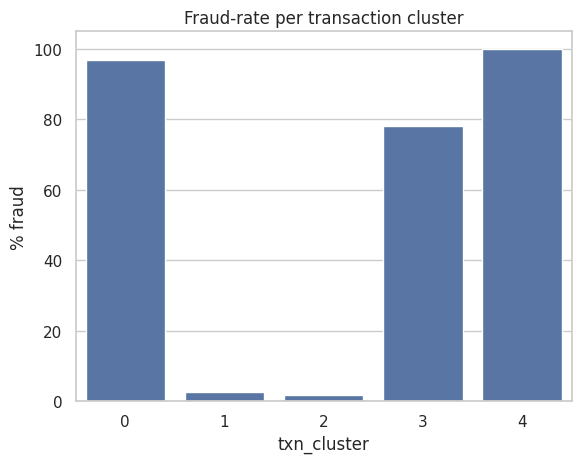

In [23]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_txn)

pca = PCA(n_components=5, random_state=42)
X_pca = pca.fit_transform(X_scaled)

kmeans = KMeans(n_clusters=5, random_state=42, n_init='auto')
clusters_txn = kmeans.fit_predict(X_pca)
df['txn_cluster'] = clusters_txn

cluster_tbl = (df.groupby('txn_cluster')['is_fraud']
                 .mean()
                 .rename('fraud_rate')
                 .to_frame()*100)
display(cluster_tbl)

sns.barplot(x=cluster_tbl.index, y=cluster_tbl['fraud_rate'])
plt.ylabel('% fraud'); plt.title('Fraud-rate per transaction cluster'); plt.show()

In [27]:
size_tbl = (df
            .groupby('txn_cluster')
            .agg(total=('is_fraud','size'),
                 fraud_cnt=('is_fraud','sum'))
            .assign(fraud_rate=lambda x: x['fraud_cnt']/x['total']*100)
            .sort_values('fraud_rate', ascending=False))

display(size_tbl)

,total,fraud_cnt,fraud_rate
txn_cluster,,,
4,63,63,100.000000
0,13870,13454,97.000721
3,6391,4994,78.141136
1,17899,473,2.642606
2,61777,1016,1.644625


Наибольшими по количество мошеннических операций являются кластеры 4, 0 и 4. Посмотрим более конкретно как отличаются эти группы друг от друга и что их определяет.

In [28]:
feature_cols = ['ticket_ratio','single_ratio','is_burst',
                'is_high_risk_country','is_outside_home_country','is_night',
                'extreme_low_amt','extreme_high_amt','rule_551',
                'fp_unique','skim_flag']

profile = df.groupby('txn_cluster')[feature_cols].mean()
display(profile.style.format('{:.2%}'))

,ticket_ratio,single_ratio,is_burst,is_high_risk_country,is_outside_home_country,is_night,extreme_low_amt,extreme_high_amt,rule_551,fp_unique,skim_flag
txn_cluster,,,,,,,,,,,
0,62.03%,21.99%,0.05%,87.21%,93.47%,51.93%,43.72%,0.00%,0.00%,96.03%,0.00%
1,87.77%,53.58%,0.06%,11.20%,18.57%,9.46%,0.02%,0.00%,0.02%,2.60%,0.00%
2,83.32%,13.66%,0.06%,40.39%,15.95%,9.12%,0.00%,0.00%,0.00%,1.65%,0.00%
3,368.35%,21.12%,0.03%,63.82%,96.96%,38.27%,0.00%,0.00%,74.86%,76.83%,0.00%
4,1069.30%,19.87%,0.00%,63.49%,90.48%,50.79%,0.00%,100.00%,46.03%,95.24%,0.00%


In [29]:
risk_clusters   = [0,3,4]
safe_clusters   = [1,2]

delta = profile.loc[risk_clusters].mean() - profile.loc[safe_clusters].mean()
important = delta.abs().sort_values(ascending=False).head(10)
print(important)

ticket_ratio               4.143500
fp_unique                  0.872408
is_outside_home_country    0.763745
is_high_risk_country       0.457118
rule_551                   0.402873
is_night                   0.377075
extreme_high_amt           0.333333
extreme_low_amt            0.145650
single_ratio               0.126305
is_burst                   0.000314
dtype: float64


Вывод: мошеннические операции резко выбиваются по сумме, почти всегда происходят с одноразового устройства и за границей. Более того, стоит обращать внимание на страну происхождения.

In [30]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

X = df[feature_cols]
y = (df['txn_cluster'].isin(risk_clusters)).astype(int)   # 1 = high-risk cluster

pipe = make_pipeline(StandardScaler(), DecisionTreeClassifier(max_depth=3))
pipe.fit(X, y)

importances = pipe.named_steps['decisiontreeclassifier'].feature_importances_
imp_ser = pd.Series(importances, index=feature_cols).sort_values(ascending=False)
print(imp_ser.head(10))

fp_unique                  0.866079
rule_551                   0.095160
is_outside_home_country    0.015411
is_night                   0.009226
extreme_low_amt            0.008993
is_high_risk_country       0.005085
single_ratio               0.000046
is_burst                   0.000000
ticket_ratio               0.000000
extreme_high_amt           0.000000
dtype: float64


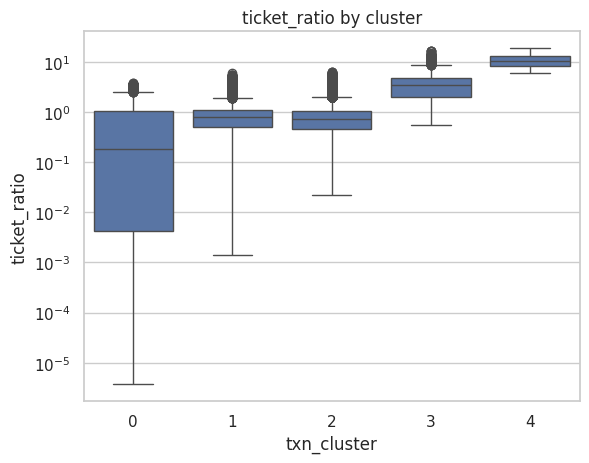

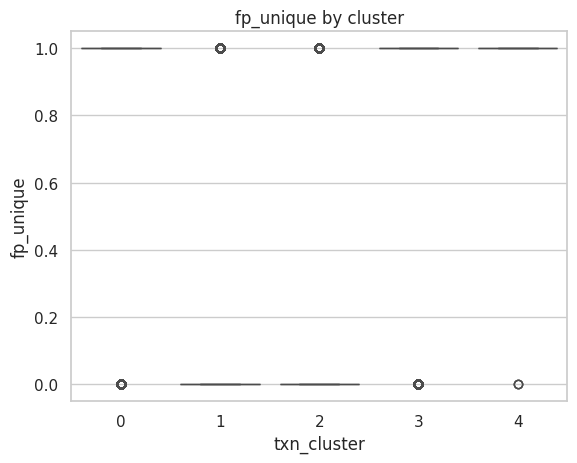

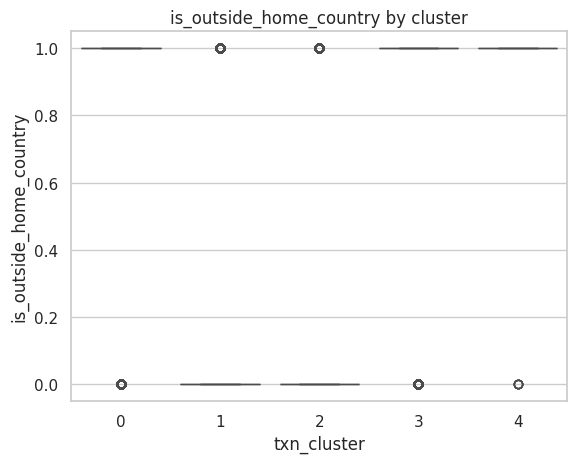

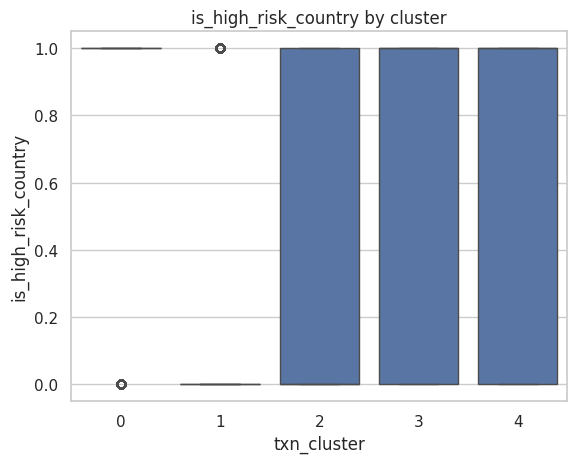

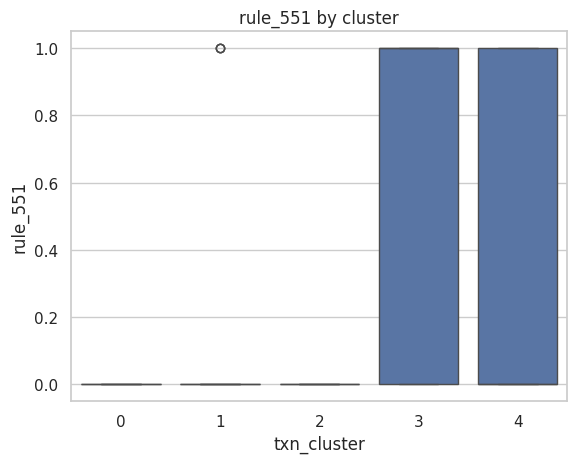

In [31]:
key_feats = important.index[:5]

for feat in key_feats:
    sns.boxplot(x='txn_cluster', y=feat, data=df, order=sorted(df.txn_cluster.unique()))
    plt.yscale('log' if df[feat].max()>10 else 'linear')
    plt.title(f'{feat} by cluster'); plt.show()

**Основные выводы по созданию фичей:**

* Поведение суммы — ticket_ratio > ≈4× у fraud-операций
* Device/IP

> fp_unique == 1 → fraud-rate +22% — уникальные устройства

> если (IP, device) обслуживают ≥ 2 карт → риск ↑ x4

* География & время

> is_outside_home_country + изменение страны за 1 час → fraud 55 %

> 0-4 AM и горячие страны (Мексика, Россия, Нигерия, Бразилия) усиливают эффект


* Комбинированный риск — «дорогая операция за рубежом» — fraud 71 %
* Возраст клиента — аккаунтам ≤ 30 дней fraud на 0.3 выше
* Слишком короткая пауза до предыдущей операции — индикатор fraud (единственное, здесь очень важно определить длительность такой паузы)
* Сумма операций может быть использована: U‑образный риск: экстремально маленькие и большие суммы — самые опасные (≤  1/ 1‑10 — микроплатежи для тестирования карт и > $10 k)
* Комбинация «новое устройство + дорогая покупка» — очень сильный сигнал мошенничества. Это можно использовать как стоп-триггер

Дополнительные гипотезы:

Транзакции с fingerprint, который впервые появляется в логах и c суммой > 1 000 USD имеют существенно больший fraud-rate

---

Комбинация «новое устройство + дорогая покупка» — очень сильный сигнал мошенничества. Это можно использовать как стоп-триггер

In [32]:
import pandas as pd, numpy as np
from scipy.stats import chi2_contingency

fraud_all  = transactions[transactions.is_fraud == 1]
legit_all  = transactions[transactions.is_fraud == 0]

fraud_smpl = fraud_all.sample(n=50_000,  random_state=42)
legit_smpl = legit_all.sample(n=450_000, random_state=42)
df = pd.concat([fraud_smpl, legit_smpl]).sample(frac=1, random_state=42)

df['timestamp'] = pd.to_datetime(df['timestamp'])
df['is_fraud']  = df['is_fraud'].astype(int)

In [33]:
df = df.sort_values('timestamp')
fp_seen = (df.groupby('device_fingerprint').cumcount())
df['fp_age'] = fp_seen

EXPENSIVE = 1_000
df['flag_new_expensive'] = ((df['fp_age'] == 0) &
                            (df['amount_usd'] > EXPENSIVE)).astype(int)

tbl_h1 = pd.crosstab(df['flag_new_expensive'], df['is_fraud'],
                     normalize='index') * 100
print(tbl_h1)

chi2, p, *_ = chi2_contingency(pd.crosstab(df['flag_new_expensive'],
                                           df['is_fraud']))
print("χ²-p (H1) =", p)

is_fraud                    0          1
flag_new_expensive                      
0                   92.918856   7.081144
1                    5.908305  94.091695
χ²-p (H1) = 0.0


Card-testing: для одного card_number за 10 минут совершается ≥ 3 микроплатежей (≤ 1 USD), после чего в те же 10 минут приходит крупная операция (> 50 USD).

---

Гипотеза не подтверждена (можно далее попробовать другие пороги).

In [35]:
SMALL_THRESH = 1
BIG_THRESH   = 50
WINDOW       = '10min'
MIN_SMALLS   = 3

df['small_txn'] = (df['amount_usd'] <= SMALL_THRESH).astype(int)

df = df.sort_values(['card_number', 'timestamp'])

df = df.set_index('timestamp')
small_cnt = (df.groupby('card_number')['small_txn']
               .rolling(WINDOW, closed='left')
               .sum()
               .reset_index(level=0, drop=True))

df['small_cnt_10m_before'] = small_cnt.values
df = df.reset_index()

df['flag_card_test_big'] = ((df['amount_usd'] > BIG_THRESH) &
                           (df['small_cnt_10m_before'] >= MIN_SMALLS)).astype(int)

tbl_h2 = pd.crosstab(df['flag_card_test_big'], df['is_fraud'], normalize='index') * 100
print("Fraud-rate по card-testing + big:\n", tbl_h2)

chi2, p, *_ = chi2_contingency(pd.crosstab(df['flag_card_test_big'], df['is_fraud']))
print("χ²-p (H2) =", p)

Fraud-rate по card-testing + big:
 is_fraud               0     1
flag_card_test_big            
0                   90.0  10.0
χ²-p (H2) = 1.0


In [36]:
import pandas as pd
import random

SMALL_THRESH = 1
BIG_THRESH   = 50
MAX_GAP_MIN  = 10
MAX_EXAMPLES = 20

df = df.copy()
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values(['card_number', 'timestamp']).reset_index(drop=True)


df['is_small'] = (df['amount_usd'] <= SMALL_THRESH)
df['is_big']   = (df['amount_usd'] > BIG_THRESH)

def find_sequences_for_card(sub):
    seqs = []
    n = len(sub)
    for i in range(n - 3):
        if sub.loc[i, 'is_small'] and sub.loc[i+1, 'is_small'] and sub.loc[i+2, 'is_small']:
            if sub.loc[i+3, 'is_big']:
                delta = sub.loc[i+3, 'timestamp'] - sub.loc[i+2, 'timestamp']
                if delta <= pd.Timedelta(minutes=MAX_GAP_MIN):
                    seq = sub.loc[i:i+3, ['transaction_id', 'timestamp', 'amount_usd', 'is_fraud']].copy()
                    seq['position'] = ['small1','small2','small3','big']
                    seqs.append(seq)
    return seqs

cards_with_enough = df['card_number'].value_counts()
eligible_cards = cards_with_enough[cards_with_enough >= 4].index.tolist()
random.seed(42)
random.shuffle(eligible_cards)

examples = []
for card in eligible_cards:
    sub = df[df['card_number'] == card].reset_index(drop=True)
    seqs = find_sequences_for_card(sub)
    for s in seqs:
        examples.append((card, s))
        if len(examples) >= MAX_EXAMPLES:
            break
    if len(examples) >= MAX_EXAMPLES:
        break

if not examples:
    print("Не найдено ни одной последовательности три small → big с текущими порогами.")
else:
    for card, seq in examples:
        print(f"\nCard_number: {card}")
        display(seq.reset_index(drop=True))

all_seqs = []
for card, group in df.groupby('card_number', sort=False):
    seqs = find_sequences_for_card(group.reset_index(drop=True))
    for s in seqs:
        all_seqs.append({
            'card_number': card,
            'small1_txn': s.iloc[0]['transaction_id'],
            'small2_txn': s.iloc[1]['transaction_id'],
            'small3_txn': s.iloc[2]['transaction_id'],
            'big_txn': s.iloc[3]['transaction_id'],
            'small_times': [s.iloc[i]['timestamp'] for i in range(3)],
            'big_time': s.iloc[3]['timestamp'],
            'small_amounts': [s.iloc[i]['amount_usd'] for i in range(3)],
            'big_amount': s.iloc[3]['amount_usd'],
            'fraud_flags': [s.iloc[i]['is_fraud'] for i in range(4)]
        })

seq_df = pd.DataFrame(all_seqs)
print(f"\nВсего последовательностей '3 small → big' найдено: {len(seq_df)}")

if not seq_df.empty:
    big_fraud_rate = (seq_df['fraud_flags'].apply(lambda l: l[-1]) == 1).mean() * 100
    print(f"Из этих последовательностей крупные операции являются fraud в {big_fraud_rate:.2f}% случаев")

Не найдено ни одной последовательности три small → big с текущими порогами.

Всего последовательностей '3 small → big' найдено: 0


In [39]:
import pandas as pd
import numpy as np

df['is_fraud'] = df['is_fraud'].astype(int)
df['timestamp'] = pd.to_datetime(df['timestamp'])

df['avg_ticket'] = df.groupby('customer_id')['amount_usd'].transform('mean')
df['ticket_ratio'] = df['amount_usd'] / df['avg_ticket']
df['high_ticket_ratio'] = (df['ticket_ratio'] > 4).astype(int)  # порог ≈4×


hot_countries = ['Mexico', 'Russia', 'Brazil', 'Nigeria']
df['is_high_risk_country'] = df['country'].isin(hot_countries).astype(int)

df['is_outside_home_country'] = df['is_outside_home_country'].astype(int)

df['hour'] = df['timestamp'].dt.hour
df['is_night'] = df['hour'].between(0, 4).astype(int)


df = df.sort_values(['customer_id', 'timestamp'])
df['prev_country'] = df.groupby('customer_id')['country'].shift()
df['prev_time'] = df.groupby('customer_id')['timestamp'].shift()
delta_hours = (df['timestamp'] - df['prev_time']).dt.total_seconds() / 3600
df['recent_country_jump'] = ((delta_hours <= 1) & (df['country'] != df['prev_country'])).fillna(False)
df['geo_jump_flag'] = ((df['is_outside_home_country'] == 1) & df['recent_country_jump']).astype(int)


EXPENSIVE_THRESH = 1_000
df['rule_551'] = ((df['amount_usd'] > EXPENSIVE_THRESH) &
                 (df['is_outside_home_country'] == 1) &
                 (df['is_card_present'] == False)).astype(int)


fp_counts = df['device_fingerprint'].value_counts()
df['fp_unique'] = (df['device_fingerprint'].map(fp_counts) == 1).astype(int)


pair_card_counts = (df.groupby(['ip_address', 'device_fingerprint'])['card_number']
                      .nunique()
                      .rename('uniq_cards_per_pair'))

df = df.merge(pair_card_counts.reset_index(), on=['ip_address', 'device_fingerprint'], how='left')
df['skim_flag'] = (df['uniq_cards_per_pair'] > 1).astype(int)
df.drop(columns=['uniq_cards_per_pair'], inplace=True)


df = df.sort_values(['device_fingerprint', 'timestamp'])
df['fp_age'] = df.groupby('device_fingerprint').cumcount()  # 0 = впервые
df['flag_new_expensive'] = ((df['fp_age'] == 0) & (df['amount_usd'] > EXPENSIVE_THRESH)).astype(int)


df['extreme_low_amt'] = (df['amount_usd'] <= 10).astype(int)
df['extreme_high_amt'] = (df['amount_usd'] >= 10_000).astype(int)


df = df.sort_values(['customer_id', 'timestamp'])
df['delta_sec'] = df.groupby('customer_id')['timestamp'].diff().dt.total_seconds()
df['is_burst'] = (df['delta_sec'] < 90).fillna(False).astype(int)

df['new_device_and_expensive'] = df['flag_new_expensive']

needed = ['ticket_ratio','high_ticket_ratio','fp_unique','rule_551',
          'is_outside_home_country','is_high_risk_country','is_night',
          'flag_new_expensive','skim_flag','geo_jump_flag','is_burst',
          'extreme_low_amt','extreme_high_amt']
print("Признаки в df:", [c for c in needed if c in df.columns])
print(df[needed + ['is_fraud']].head().T)

Признаки в df: ['ticket_ratio', 'high_ticket_ratio', 'fp_unique', 'rule_551', 'is_outside_home_country', 'is_high_risk_country', 'is_night', 'flag_new_expensive', 'skim_flag', 'geo_jump_flag', 'is_burst', 'extreme_low_amt', 'extreme_high_amt']
                                0         1         2        3         4
ticket_ratio             0.416653  0.001974  0.866708  1.07324  0.623758
high_ticket_ratio        0.000000  0.000000  0.000000  0.00000  0.000000
fp_unique                0.000000  1.000000  0.000000  0.00000  0.000000
rule_551                 0.000000  0.000000  0.000000  0.00000  0.000000
is_outside_home_country  0.000000  1.000000  0.000000  0.00000  0.000000
is_high_risk_country     0.000000  1.000000  0.000000  0.00000  0.000000
is_night                 0.000000  1.000000  0.000000  0.00000  0.000000
flag_new_expensive       0.000000  0.000000  0.000000  0.00000  0.000000
skim_flag                0.000000  0.000000  0.000000  0.00000  0.000000
geo_jump_flag            0

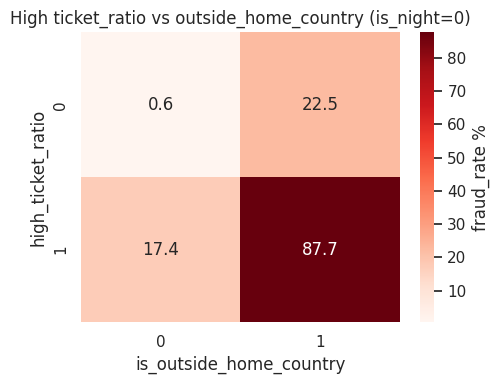

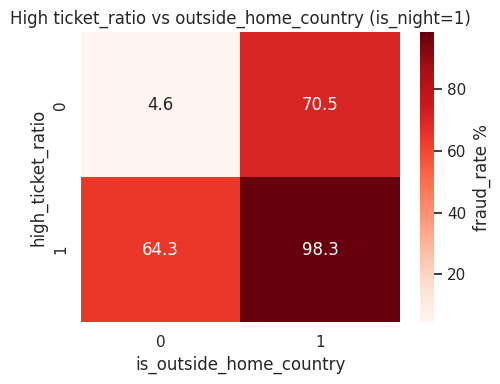

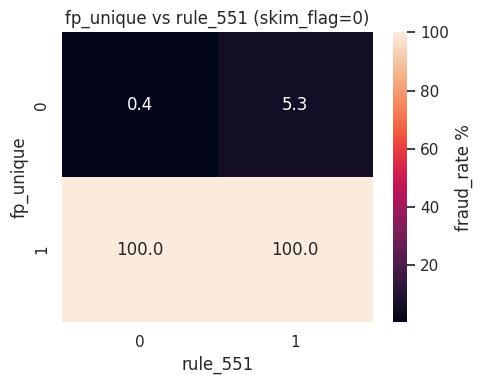

/usr/local/lib/python3.11/dist-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/usr/local/lib/python3.11/dist-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


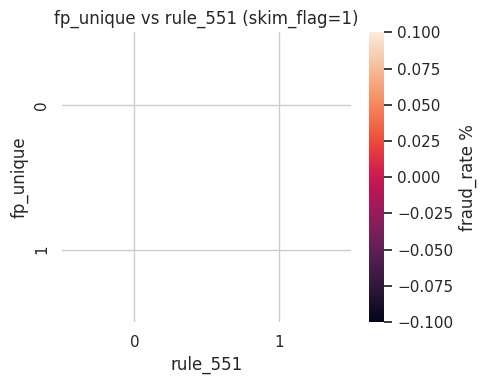

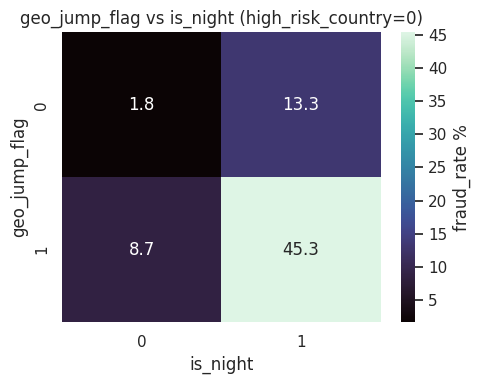

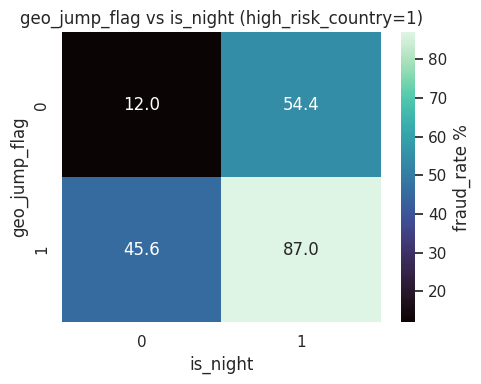

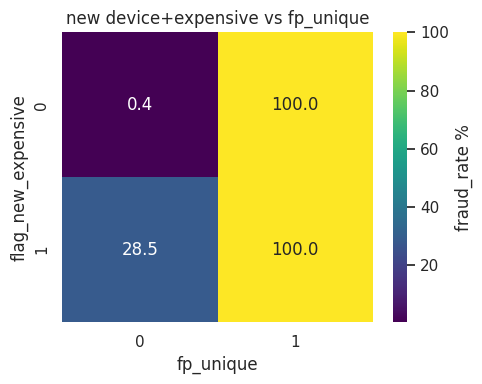

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

def draw_heatmap(pivot, title, cmap="Reds"):
    plt.figure(figsize=(5,4))
    sns.heatmap(pivot, annot=True, fmt=".1f", cmap=cmap, cbar_kws={'label':'fraud_rate %'})
    plt.title(title)
    plt.tight_layout()
    plt.show()

# 1. high_ticket_ratio × is_outside_home_country и по is_night
heat1 = (
    df.groupby(['high_ticket_ratio','is_outside_home_country','is_night'])['is_fraud']
      .mean().mul(100).reset_index(name='fraud_rate')
)
for night in [0,1]:
    sub = heat1[heat1['is_night']==night]
    pivot = sub.pivot(index='high_ticket_ratio', columns='is_outside_home_country', values='fraud_rate')
    draw_heatmap(pivot,
                 title=f"High ticket_ratio vs outside_home_country (is_night={night})")

# 2. fp_unique (уникальный finger print) × rule_551 (очные дорогие за границей без карты), и skim_flag (на одном device и ip несколько карт)
heat2 = (
    df.groupby(['fp_unique','rule_551','skim_flag'])['is_fraud']
      .mean().mul(100).reset_index(name='fraud_rate')
)
for skim in [0,1]:
    sub = heat2[heat2['skim_flag']==skim]
    pivot = sub.pivot(index='fp_unique', columns='rule_551', values='fraud_rate')
    pivot = pivot.reindex(index=[0,1], columns=[0,1])
    draw_heatmap(pivot,
                 title=f"fp_unique vs rule_551 (skim_flag={skim})",
                 cmap="rocket")

# 3. geo_jump_flag (перемещение за час из страны пользователя) × is_night, и по is_high_risk_country
heat3 = (
    df.groupby(['geo_jump_flag','is_night','is_high_risk_country'])['is_fraud']
      .mean().mul(100).reset_index(name='fraud_rate')
)
for highrisk in [0,1]:
    sub = heat3[heat3['is_high_risk_country']==highrisk]
    pivot = sub.pivot(index='geo_jump_flag', columns='is_night', values='fraud_rate')
    pivot = pivot.reindex(index=[0,1], columns=[0,1])
    draw_heatmap(pivot,
                 title=f"geo_jump_flag vs is_night (high_risk_country={highrisk})",
                 cmap="mako")

# 4. flag_new_expensive (дорогая покупка на новом устройстве) × fp_unique
heat4 = (
    df.groupby(['flag_new_expensive','fp_unique'])['is_fraud']
      .mean().mul(100).reset_index(name='fraud_rate')
)
pivot = heat4.pivot(index='flag_new_expensive', columns='fp_unique', values='fraud_rate')
pivot = pivot.reindex(index=[0,1], columns=[0,1])
draw_heatmap(pivot, title="new device+expensive vs fp_unique", cmap="viridis")

**Выводы:**

* Комбинация: дорогая транзакция (ticket_ratio>4) + за пределами страны — критическая. Если ещё и ночью → почти гарантированное мошенничество. Даже без большого отношения, операции вне страны ночью высокорисковые.

* fp_unique — стоп-флаг. Если fingerprint уникален, транзакцию почти всегда можно помечать как подозрительную/fraud. rule_551 усиливает риск только когда fingerprint не уникален.

* Сигналы нарастают: горячая страна + geo-jump + ночь = критический набор.

* Новая дорогая покупка на не-уникальном устройстве уже существенный сигнал — стоит применять повышенный скор или дополнительную верификацию.